In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib

In [2]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

Ignore next 2 cells

%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

#### Read the merged dataframe "dfmg.csv" which was built using MEOP_Preprocessing_data_SO.ipynb

The pre-built "dfmg.csv" is also available for download from: https://drive.google.com/open?id=1GeUjUwLfuU840JQmxzCFKo8rrxv7eom6

In [3]:
dfmg = pd.read_csv("dfmg.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

The next few cells import necessary custom written functions

In [4]:
import plot_theta_sal
importlib.reload(plot_theta_sal)

import plot_surfbot_vsTime as pltsurfbot
import plot_topView_contourf as topView

Defining regions, water masses, and data selection masks

In [4]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [5]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [6]:
def play_beep():
    import os
    duration = 1  # second
    freq = np.random.randint(400,800, 10)  # Hz
    for i in range(len(freq)):
        os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq[i]))

In [7]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [8]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27) #
CDW2 = (dfmg.CTEMP > 1.5) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27) #

In [9]:
len(dfmg.loc[CDW & mCDW]) / len(dfmg[mCDW])

0.0

In [26]:
print(len(dfmg[DSW]), len(dfmg[ISW]), len(dfmg[lssw]), len(dfmg.loc[DSW & ISW]), 
      len(dfmg[ISW & lssw]), len(dfmg[lssw & mCDW]), len(dfmg[CDW]), len(dfmg[CDW2]) )

180222 126675 182025 71810 0 4 386095 30659


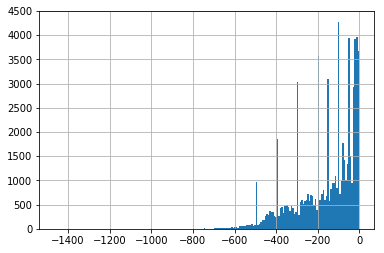

count    69842.000000
mean      -163.943765
std        141.895985
min      -1464.063980
25%       -257.233451
50%       -123.724801
75%        -49.468875
max         -1.979322
Name: DEPTH, dtype: float64

In [11]:
dfmg.loc[lssw & gline_le_75km, 'DEPTH'].hist(bins=200)
plt.show()
dfmg.loc[lssw & gline_le_75km, 'DEPTH'].describe()

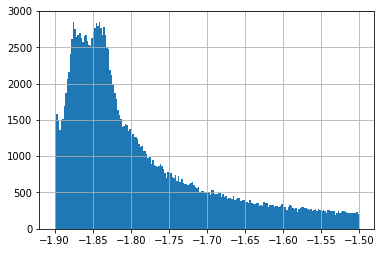

In [12]:
dfmg.loc[lssw, 'CTEMP'].hist(bins=200)
plt.show()

# $\theta$ - S Plots

In [42]:
sal_gt_344 = (dfmg['PSAL_ADJUSTED'] > 34.4) #& (dfmg.CTEMP < -1.7)
sal_gt_345 = (dfmg['PSAL_ADJUSTED'] > 34.5) #& (dfmg.CTEMP < -1.7)
sal_lt_345 = (dfmg['PSAL_ADJUSTED'] < 34.5) & (dfmg.CTEMP > -1.7)

In [9]:
regions_list = [Ross & ~gline_le_75km, Weddell& ~gline_le_75km, CDP& ~gline_le_75km,
                Adelie& ~gline_le_75km, Prydz& ~gline_le_75km,  Knox& ~gline_le_75km]
regions_names = ["Ross", "Weddell", "CDP", "Adelie", "Prydz",  "Knox"]

for i in range(len(regions_list)):
    if(i < 6):
        mask = regions_list[i]  & sal_gt_345 & sel_months(dfmg, [3])
    else:
        mask = regions_list[i]  & sal_gt_344 & sel_months(dfmg, [1,2,3])
    cutoff_depth = -250 #min(-250, dfmg.loc[mask, 'DEPTH'].quantile(0.9))
    depth_mask = (dfmg.DEPTH <= cutoff_depth)
    print(str(regions_names[i])+"A2", dfmg.loc[mask, 'DEPTH'].quantile(0.9), 
    dfmg.loc[mask, 'DEPTH'].quantile(0.5), 
    len(dfmg.loc[regions_list[i] & depth_mask, 'PROFILE_NUMBER'].unique()) / 
          len(dfmg.loc[regions_list[i], 'PROFILE_NUMBER'].unique()) * 100., dfmg.loc[regions_list[i] & depth_mask, 'DEPTH'].max(),"\n")

RossA2 -29.684411243351388 -134.53553823970472 51.718344279822816 -250.196899444 

WeddellA2 -167.17036732589148 -322.3689043286331 62.05284684801662 -250.192559407 

CDPA2 -167.66677694196704 -360.0675818711049 84.7372810675563 -250.361935021 

AdelieA2 -126.7044512014794 -323.53371726788356 92.38625812441968 -251.34018925 

PrydzA2 -140.53412593438279 -296.80364065900244 74.0625 -250.470797683 

KnoxA2 -148.50380099658952 -369.994905207819 88.3676268861454 -250.374918238 



In [12]:
!mkdir ./Images/TSplots

## Salinity and density histograms
Why does A1 have a 2nd water mass that is more dense ($S > 35$)?? Does it form in a more Southern region? Data spans the latitudes and is restricted to Eastern RS. Let's investigate...

In [13]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH'],
      dtype='object')

In [10]:
def find_waterMassThickness(df, computeCDW=True, computeDSW=True, months=[], zlowest=None, zbin=10.0):
    
    if months:
        monthmask = df.JULD.dt.month.isin(months)
        timeSlice = df.loc[monthmask]
    else:
        timeSlice = df
    if not zlowest:
        zlowest = timeSlice.DEPTH.quantile(0.05)
        
    number_bins = np.abs(zlowest) // zbin
    depth_bins = np.linspace(zlowest, 0, number_bins)
    
    salmean = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins)).PSAL_ADJUSTED.mean().values
    thetamean = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins)).CTEMP.mean().values
    
    DSWbins = len(salmean[(salmean >= 34.5) & (thetamean <= -1.7)])
    DSWthickness = DSWbins * zbin
    
    lsswbins = len(salmean[(salmean >= 34.3) & (salmean < 34.5) & (thetamean <= -1.5) & (depth_bins[1:] <-100)])
    lsswthickness = lsswbins * zbin
        
    ISWbins = len(thetamean[(thetamean < -1.9) & (depth_bins[1:] <-100)])
    ISWthickness = ISWbins * zbin
    
    CDWbins = len(salmean[(salmean >= 34.5) & (thetamean >= 0.0)])
    CDWthickness = CDWbins * zbin
    
    mCDWbins = len(salmean[(salmean >= 34.5) & (thetamean >= -0.5) & (thetamean < 0.0)])
    mCDWthickness = mCDWbins * zbin
    
    return DSWthickness, lsswthickness, ISWthickness, CDWthickness, mCDWthickness

In [10]:
dfmg.loc[Weddell & gline_le_75km & month_mask[8]].DEPTH.quantile(0.05)

-700.4029932480859

In [11]:
find_waterMassThickness(dfmg.loc[Weddell & gline_le_75km & month_mask[8]])

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


(690.0, 0.0, 540.0, 0.0, 0.0)

In [29]:
A1 = gline_le_75km
A2 = ~gline_le_75km

regions1 = [Weddell & A1, CDP & A1,    EPB & A1,   
            Weddell & A2, CDP & A2,    EPB & A2,   
            WPB & A1,     Adelie & A1, Ross & A1, 
            WPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) EPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) EPBA2", 
          "(g) WPBA1","(h) ACA1", "(i) RSA1",
          "(j) WPBA2","(k) ACA2", "(l) RSA2" ] 

print("Region  ", "\t", "DSW Pct ", "\t", "LSSW Pct")
wmpct = []
for i in range(len(regions1)):
    wmpct.append(np.array([len(dfmg.loc[DSW & regions1[i], "CTEMP"].notnull()) / float(len(dfmg.loc[regions1[i], "CTEMP"].notnull())) * 100., 
                len(dfmg.loc[lssw & regions1[i], "CTEMP"].notnull()) / len(dfmg.loc[regions1[i], "CTEMP"].notnull())*100.]) )
    
    print(titles1[i], "\t", wmpct[i][0],"\t", wmpct[i][1])


Region   	 DSW Pct  	 LSSW Pct
(a) WSA1 	 15.7374052368 	 19.5386848755
(b) CDA1 	 10.494670675 	 8.47772615469
(c) EPBA1 	 1.70386103756 	 5.49855974861
(d) WSA2 	 6.47116866265 	 20.4857262577
(e) CDA2 	 0.64278748116 	 9.38026420782
(f) EPBA2 	 6.70351627826 	 12.3330365093
(g) WPBA1 	 28.5726424914 	 17.8361268668
(h) ACA1 	 15.1052928457 	 9.13673968224
(i) RSA1 	 23.7571200729 	 4.08065618592
(j) WPBA2 	 12.4942566979 	 11.2140944595
(k) ACA2 	 0.217207035389 	 1.35621953804
(l) RSA2 	 31.7043821839 	 5.98329741379


In [32]:
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

DSWthickness2 = np.zeros(len(regions2))
lsswthickness2 = np.zeros(len(regions2))
ISWthickness2 = np.zeros(len(regions2))
CDWthickness2 = np.zeros(len(regions2))
mCDWthickness2 = np.zeros(len(regions2))

print("Region  ", "\t", "DSW Pct ", "\t", "LSSW Pct")
wmpct = []
for i in range(len(regions2)):
    wmpct.append(np.array([round(len(dfmg.loc[DSW & regions2[i], "CTEMP"].notnull()) / float(len(dfmg.loc[regions2[i], "CTEMP"].notnull())) * 100., 4), 
                round(len(dfmg.loc[lssw & regions2[i], "CTEMP"].notnull()) / len(dfmg.loc[regions2[i], "CTEMP"].notnull())*100.,4)]) )
    
    print(titles2[i], "\t", wmpct[i][0],"\t", wmpct[i][1])


Region   	 DSW Pct  	 LSSW Pct
(a) PMCA1 	 0.0329 	 12.9313
(b) PHCA1 	 0.0 	 2.3595
(c) LACA1 	 0.1444 	 46.9023
(d) PMCA2 	 0.0072 	 19.1206
(e) PHCA2 	 0.0 	 1.9005
(f) LACA2 	 0.1831 	 12.1691
(g) KCA1 	 0.2428 	 14.7972
(h) ASA1 	 0.0009 	 0.1918
(i) BSA1 	 0.0 	 0.0142
(j) KCA2 	 0.1143 	 4.8547
(k) ASA2 	 0.0031 	 0.0834
(l) BSA2 	 0.0037 	 0.3368


In [9]:
import plot_waterMassThickness as pltwmthk
importlib.reload(pltwmthk)

<module 'plot_waterMassThickness' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in greater
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in greater_equal
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in less_equal
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:55: RuntimeWarning: invalid value encountered in greater_equal
  lsswbins = ( (salmean >= 34.3) & (salmean <= 34.4) & (thetamean <= -1.5)

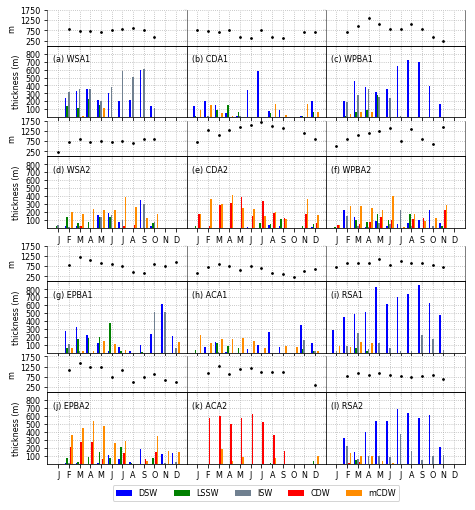

In [10]:
A1 = gline_le_75km
A2 = ~gline_le_75km

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 

yticks = list(np.arange(100, 820, 100))
yticks_dod = list(np.arange(250,2000,500))
DSWthickness1, lsswthickness1, ISWthickness1, mCDWthickness1, CDWthickness1, zlowest1 = pltwmthk.plot_array_waterMassThickness(dfmg,
                                                              regions1, titles1, ht=9, save=True, ymax=900,
                                                         savename="./Images/waterMassBudgets/array1.png", yticks=yticks, 
                                                            retValue=True, yticks_dod=yticks_dod, ymax_dod=None)

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in greater
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in greater_equal
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:54: RuntimeWarning: invalid value encountered in less_equal
  DSWbins = ((salmean > 34.4) & (gammamean >= 28.27) & (thetamean <= -1.8) )                  # Williams et al. 2016
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:55: RuntimeWarning: invalid value encountered in greater_equal
  lsswbins = ( (salmean >= 34.3) & (salmean <= 34.4) & (thetamean <= -1.5)

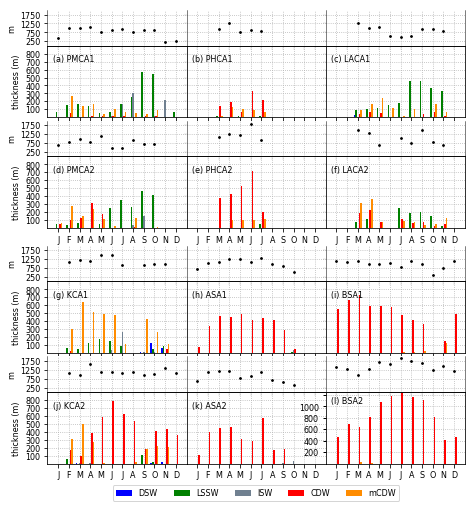

In [11]:
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

yticks = list(np.arange(100, 820, 100)) 
yticks_dod = list(np.arange(250,2000,500))
DSWthickness2, lsswthickness2, ISWthickness2, mCDWthickness2, CDWthickness2, zlowest2 = pltwmthk.plot_array_waterMassThickness(dfmg, 
                                     regions2, titles2, ht=9, save=True, ymax=900, retValue = True,
                                       savename="./Images/waterMassBudgets/array2.png", yticks=yticks, 
                                       yticks_dod=yticks_dod, ymax_dod=2000)

In [12]:
DSWthickness12 = np.append(DSWthickness1.ravel(), DSWthickness2.ravel())
ISWthickness12 = np.append(ISWthickness1.ravel(), ISWthickness2.ravel())
lsswthickness12 = np.append(lsswthickness1.ravel(), lsswthickness2.ravel())
CDWthickness12 = np.append(CDWthickness1.ravel(), CDWthickness2.ravel())
mCDWthickness12 = np.append(mCDWthickness1.ravel(), mCDWthickness2.ravel())
zlowest12 = np.append(zlowest1.ravel(), zlowest2.ravel())
titles = []
for t in titles1:
    titles.append([t.split()[1] ]*12)
for t in titles2:
    titles.append([t.split()[1] ]*12)

ind = np.arange(len(DSWthickness12))
waterMassThickness = pd.DataFrame({'DSW':pd.Series(DSWthickness12, index=ind), 
                                   'ISW':pd.Series(ISWthickness12, index=ind),
                                   'LSSW':pd.Series(lsswthickness12, index=ind),
                                   'mCDW':pd.Series(mCDWthickness12, index=ind),
                                   'CDW':pd.Series(CDWthickness12, index=ind),
                                   'zlowest':pd.Series(zlowest12, index=ind),
                                   'month':pd.Series(list(np.arange(1,13,1))*(len(DSWthickness1) + len(DSWthickness2)), index=ind),
                                   'region': pd.Series(np.array(titles).ravel(), index=ind)
                                  })

In [207]:
c = 0
for r in (regions1+regions2):
    print(titles[c][0], dfmg.loc[r, 'CTEMP'].mean())
    c+=1

WSA1 -1.8729040945152733
CDA1 -1.5846358886725427
WPBA1 -1.8187039187757674
WSA2 -1.6954351513033892
CDA2 -1.0415490194820745
WPBA2 -1.614517268594006
EPBA1 -1.671415708672424
ACA1 -1.7463301985945545
RSA1 -1.663115999617863
EPBA2 -1.5837170132044924
ACA2 0.058515067818746984
RSA2 -1.7560526782784676
PMCA1 -1.8099252233734209
PHCA1 -1.2906424620593009
LACA1 -1.7999544033546349
PMCA2 -1.3722985576082634
PHCA2 -0.8802580865901882
LACA2 -1.4688701530824069
KCA1 -1.6702822179548997
ASA1 -1.2838794473285162
BSA1 -0.5628992691590184
KCA2 -0.45446754958055746
ASA2 -1.1984912643291283
BSA2 0.07332160917600071


In [15]:
A1regions = waterMassThickness.region.str.contains('A1')
waterMassThickness[A1regions].groupby('region').mean().sort_values('DSW')

,CDW,DSW,ISW,LSSW,mCDW,month,zlowest
region,,,,,,,
ASA1,345.000000,0.000000,4.000000,1.000000,0.000000,6.5,-1007.807982
BSA1,468.333333,0.000000,0.000000,0.000000,14.166667,6.5,-964.558568
PHCA1,190.000000,0.000000,0.000000,8.000000,82.000000,6.5,-920.911979
PMCA1,12.500000,0.000000,58.333333,187.500000,80.000000,6.5,-762.773598
LACA1,28.888889,3.333333,0.000000,247.777778,107.777778,6.5,-848.935904
KCA1,8.888889,21.111111,35.555556,86.666667,370.000000,6.5,-1131.216095
ACA1,0.000000,97.500000,16.666667,31.666667,106.666667,6.5,-566.787577
CDA1,0.000000,170.000000,1.818182,40.909091,68.181818,6.5,-603.693808
EPBA1,0.000000,204.545455,110.000000,93.636364,49.090909,6.5,-816.014954


In [465]:
regionmask = waterMassThickness.region.str.contains("A1")
waterMassThickness[regionmask].groupby('region').mean().sort_values('mCDW')

,CDW,DSW,ISW,LSSW,mCDW,month,DSW_flag,CDW_flag,mCDW_flag,LSSW_flag
region,,,,,,,,,,
ASA1,345.000000,0.000000,4.000000,1.000000,0.000000,6.5,0.000000,0.833333,0.000000,0.083333
WSA1,0.000000,291.111111,381.111111,71.111111,13.333333,6.5,0.750000,0.000000,0.166667,0.333333
BSA1,468.333333,0.000000,0.000000,0.000000,14.166667,6.5,0.000000,0.916667,0.333333,0.000000
WPBA1,0.000000,433.000000,133.000000,45.000000,17.000000,6.5,0.833333,0.000000,0.250000,0.333333
RSA1,0.000000,599.090909,100.909091,7.272727,40.000000,6.5,0.916667,0.000000,0.333333,0.166667
EPBA1,0.000000,204.545455,110.000000,93.636364,49.090909,6.5,0.916667,0.000000,0.583333,0.583333
CDA1,0.000000,170.000000,1.818182,40.909091,68.181818,6.5,0.916667,0.000000,0.666667,0.583333
PMCA1,12.500000,0.000000,58.333333,187.500000,80.000000,6.5,0.000000,0.583333,0.750000,0.916667
PHCA1,190.000000,0.000000,0.000000,8.000000,82.000000,6.5,0.000000,0.416667,0.416667,0.250000


In [243]:
regionMask = waterMassThickness.region.str.contains("KCA1")
waterMassThickness[regionMask]

,CDW,DSW,ISW,LSSW,mCDW,month,region
216,NaN,NaN,NaN,NaN,NaN,1,KCA1
217,30.0,0.0,0.0,60.0,300.0,2,KCA1
218,0.0,0.0,0.0,50.0,640.0,3,KCA1
219,0.0,0.0,0.0,120.0,510.0,4,KCA1
220,0.0,0.0,0.0,170.0,490.0,5,KCA1
221,0.0,0.0,40.0,150.0,480.0,6,KCA1
222,0.0,0.0,260.0,90.0,110.0,7,KCA1
223,NaN,NaN,NaN,NaN,NaN,8,KCA1
224,0.0,10.0,10.0,0.0,430.0,9,KCA1
225,0.0,120.0,10.0,50.0,260.0,10,KCA1


In [245]:
dfmg.loc[Knox & gline_le_75km & month_mask[10], 'DEPTH'].min()

-958.16136232352437

$$P(DSW | CDW) = \frac{P(DSW \cap CDW)}{P(CDW)}$$

In [15]:
DSWgt20 = waterMassThickness.DSW > 0
waterMassThickness.loc[DSWgt20, "DSW_flag"] = 1
waterMassThickness.loc[~DSWgt20, "DSW_flag"] = 0

CDWgt20 = waterMassThickness.CDW > 0
waterMassThickness.loc[CDWgt20, "CDW_flag"] = 1
waterMassThickness.loc[~CDWgt20, "CDW_flag"] = 0

mCDWgt20 = waterMassThickness.mCDW > 0
waterMassThickness.loc[mCDWgt20, 'mCDW_flag'] = 1
waterMassThickness.loc[~mCDWgt20, 'mCDW_flag'] = 0

LSSWgt20 = waterMassThickness.LSSW > 0
waterMassThickness.loc[LSSWgt20, 'LSSW_flag'] = 1
waterMassThickness.loc[~LSSWgt20, 'LSSW_flag'] = 0

In [14]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman'],
      dtype='object')

In [42]:
dfmg.loc[Adelie, ['TEMP_ADJUSTED_ERROR', 'PLATFORM_NUMBER', 'JULD']].describe()

,TEMP_ADJUSTED_ERROR
count,90165.000000
mean,0.109535
std,0.053003
min,0.050000
25%,0.050000
50%,0.100000
75%,0.100000
max,0.200000


In [53]:
temperror02 = dfmg.TEMP_ADJUSTED_ERROR > 0.055
dfmg.loc[temperror02 & Weddell, ['PLATFORM_NUMBER', 'TEMP_ADJUSTED_ERROR', 'PSAL_ADJUSTED_ERROR', 'JULD']]

,PLATFORM_NUMBER,TEMP_ADJUSTED_ERROR,PSAL_ADJUSTED_ERROR,JULD


In [16]:
import compute_waterMassProbabilities as wmprob
importlib.reload(wmprob)

<module 'compute_waterMassProbabilities' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/compute_waterMassProbabilities.py'>

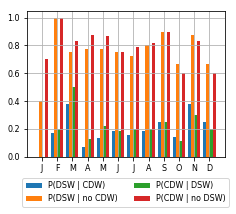

 P(DSW | CDW)= 0.189750527251 
 P(DSW | no CDW)= 0.757596801347 
 P(CDW | DSW)= 0.207512626263 
 P(CDW | no DSW)= 0.796852453102


In [17]:
wmprob.compute_prob_unweighted(waterMassThickness, save=True, savename="./Images/waterMassBudgets/wmprobUnweighted.png")

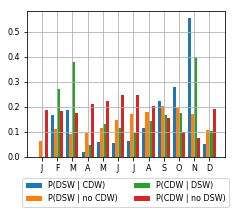

 P(DSW | CDW)= 0.147515359515 
 P(DSW | no CDW)= 0.136794191191 
 P(CDW | DSW)= 0.168612589926 
 P(CDW | no DSW)= 0.182100052274


In [18]:
wmprob.compute_monthly_conditional_prob_weighted(waterMassThickness, save=True, 
                                                 savename="./Images/waterMassBudgets/wmprobWeighted.png")

In [25]:
waterMassThickness = pd.read_csv("waterMassThickness.csv")
del(waterMassThickness["Unnamed: 0"])

In [27]:
waterMassThickness["tCDW"] = waterMassThickness.CDW + waterMassThickness.mCDW

In [28]:
waterMassThickness.columns

Index(['CDW', 'DSW', 'ISW', 'LSSW', 'mCDW', 'month', 'region', 'zlowest',
       'windMonMean', 'v10SlopeMonMean', 'u10SlopeMonMean', 'u10MonMean',
       'v10MonMean', 'stress_curl_slope_MonMean', 'neg_u10SlopeMonMean',
       'neg_stress_curl', 'ShelfWidth', 'tCDW'],
      dtype='object')

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


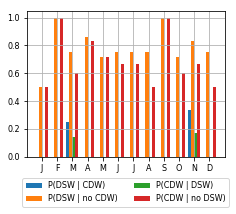

 P(DSW | CDW)= 0.0486111111111 
 P(DSW | no CDW)= 0.780753968254 
 P(CDW | DSW)= 0.0257936507937 
 P(CDW | no DSW)= 0.687301587302


In [33]:
A1regions = waterMassThickness.region.str.contains('A1')
wmprob.compute_prob_unweighted(waterMassThickness[A1regions], save=True,
                               savename="./Images/waterMassBudgets/wmA1probUnweighted.eps")

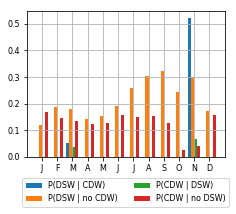

 P(DSW | CDW)= 0.0478778467909 
 P(DSW | no CDW)= 0.214052322965 
 P(CDW | DSW)= 0.00846225756082 
 P(CDW | no DSW)= 0.125288346253


In [20]:
wmprob.compute_monthly_conditional_prob_weighted(waterMassThickness[A1regions], save=True, 
                                                 savename="./Images/waterMassBudgets/wmA1probWeighted.png")

In [21]:
def compute_monthly_conditional_prob(dfwm, wm1='DSW', wm2='CDW', save=False, savename='untitled.png', 
                                     show=True, width=90/25.4, height=90/25.4):
    matplotlib.rcParams.update({'font.size': 8})
    prob_DSW = np.zeros(12)
    prob_noDSW = np.zeros(12)
    prob_CDW = np.zeros(12)
    prob_noCDW = np.zeros(12)
    
    prob_DSW_cap_CDW = np.zeros(12)
    prob_DSW_cap_noCDW = np.zeros(12)
    prob_CDW_cap_noDSW = np.zeros(12)
    
    prob_DSW_cond_CDW = np.zeros(12)
    prob_DSW_cond_noCDW = np.zeros(12)
    prob_CDW_cond_DSW = np.zeros(12)
    prob_CDW_cond_noDSW = np.zeros(12)
    
    wm1gt0 = dfwm[wm1] > 0
    wm2gt0 = dfwm[wm2] > 0
    DSW_cap_CDW = wm1gt0 & wm2gt0
    DSW_cap_noCDW = wm1gt0 & ~wm2gt0
    CDW_cap_noDSW = ~wm1gt0 & wm2gt0
    
    noNull = ~dfwm["DSW"].isnull()
    
    for i in range(12):
        monthMask = (dfwm.month.isin([i+1]) & noNull)
    
        prob_DSW[i] = np.nansum(dfwm.loc[monthMask, wm1]) / np.abs(np.nansum(dfwm.loc[monthMask, 'zlowest']))
        prob_CDW[i] = np.nansum(dfwm.loc[monthMask, wm2]) / np.abs(np.nansum(dfwm.loc[monthMask, 'zlowest']))
        prob_noCDW[i] = 1 - prob_CDW[i]
        prob_noDSW[i] = 1 - prob_DSW[i]
        
        prob_DSW_cap_CDW[i] = (np.nansum(dfwm.loc[monthMask & DSW_cap_CDW, wm1]) + np.nansum(dfwm.loc[monthMask & DSW_cap_CDW, wm2]) ) / np.abs(np.nansum(dfwm.loc[monthMask, 'zlowest']))
        prob_DSW_cap_noCDW[i] = np.nansum(dfwm.loc[monthMask & DSW_cap_noCDW, wm1]) / np.abs(np.nansum(dfwm.loc[monthMask, 'zlowest']))
        prob_CDW_cap_noDSW[i] = np.nansum(dfwm.loc[monthMask & CDW_cap_noDSW, wm2]) / np.abs(np.nansum(dfwm.loc[monthMask, 'zlowest']))
        
    prob_DSW_cond_CDW = prob_DSW_cap_CDW / prob_CDW
    prob_DSW_cond_noCDW = prob_DSW_cap_noCDW / prob_noCDW
    
    prob_CDW_cond_DSW = prob_DSW_cap_CDW / prob_DSW
    prob_CDW_cond_noDSW = prob_CDW_cap_noDSW / prob_noDSW
    
    timeaxis = np.arange(1,13,1)
    wd = 0.2
    wm1 = wm1
    wm2 = wm2
    
    fig = plt.figure(1, figsize=(width, height))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2])
    ax = plt.subplot(gs[0,0])
    
    ax.bar(timeaxis-1.5*wd, prob_DSW_cond_CDW, wd, label='P('+wm1+' | '+wm2+')')
    ax.bar(timeaxis-wd*0.5, prob_DSW_cond_noCDW, wd, label='P('+wm1+' | no '+wm2+')')
    
    ax.bar(timeaxis+wd*0.5, prob_CDW_cond_DSW, wd, label='P('+wm2+' | '+wm1+')')
    plt.bar(timeaxis+wd*1.5, prob_CDW_cond_noDSW, wd, label='P('+wm2+' | no '+wm1+')')
    
    ax.set_xticks(timeaxis)
    timeaxis_ticklabel = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    ax.set_xticklabels(timeaxis_ticklabel)
    
    handles, labels = ax.get_legend_handles_labels()
    axlegend = plt.subplot(gs[1,0])
    axlegend.legend(handles, labels, ncol=2, loc=9)
    axlegend.set_yticklabels([])
    axlegend.set_yticks([])
    axlegend.set_xticklabels([])
    axlegend.set_xticks([])
    axlegend.spines["top"].set_visible(False)
    axlegend.spines["right"].set_visible(False)
    axlegend.spines["left"].set_visible(False)
    axlegend.spines["bottom"].set_visible(False)

    ax.grid()
    
    if save:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    
    print(' P('+wm1+' | '+wm2+')=',prob_DSW_cond_CDW.mean(),"\n", 'P('+wm1+' | no '+wm2+')=', prob_DSW_cond_noCDW.mean(), 
          "\n", 'P('+wm2+' | '+wm1+')=', prob_CDW_cond_DSW.mean(), "\n", 
          'P('+wm2+' | no '+wm1+')=',prob_CDW_cond_noDSW.mean())


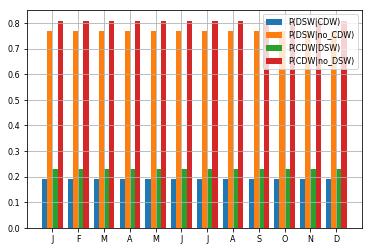

 P(DSW|CDW)= 0.190839694656 
 P(DSW|no_CDW)= 0.768518518519 
 P(CDW|DSW)= 0.231481481481 
 P(CDW|no_DSW)= 0.809160305344


In [421]:
compute_monthly_conditional_prob(waterMassThickness, save=True, 
                                 savename="./Images/waterMassBudgets/probabilities_DSW_CDW.png")

In [410]:
regionsA1 = waterMassThickness.region.str.contains("A1")

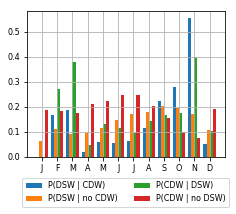

 P(DSW | CDW)= 0.147515359515 
 P(DSW | no CDW)= 0.136794191191 
 P(CDW | DSW)= 0.168612589926 
 P(CDW | no DSW)= 0.182100052274


In [22]:
compute_monthly_conditional_prob(waterMassThickness, save=False)
#savename="./Images/waterMassBudgets/probabilities_DSW_CDW.png"

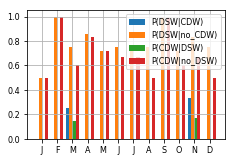

 P(DSW|CDW)= 0.0486111111111 
 P(DSW|no_CDW)= 0.780753968254 
 P(CDW|DSW)= 0.0257936507937 
 P(CDW|no_DSW)= 0.687301587302


In [428]:
compute_monthly_conditional_prob(waterMassThickness[regionsA1], save=True, 
                                 savename="./Images/waterMassBudgets/probabilities_DSW_CDW_A1.png")

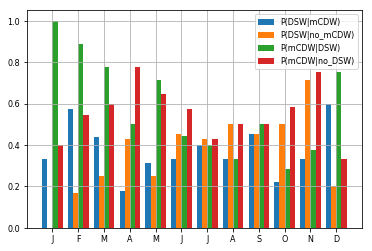

 P(DSW|mCDW)= 0.375666680814 
 P(DSW|no_mCDW)= 0.362265512266 
 P(mCDW|DSW)= 0.580787037037 
 P(mCDW|no_DSW)= 0.553079817786


In [414]:
compute_monthly_conditional_prob(waterMassThickness, flag2='mCDW_flag', 
                                 save=True, savename="./Images/waterMassBudgets/probabilities_DSW_mCDW.png")

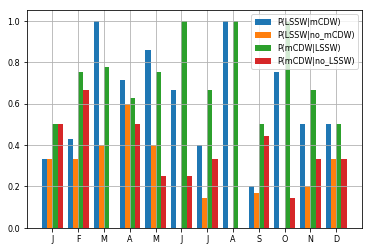

 P(LSSW|mCDW)= 0.6125 
 P(LSSW|no_mCDW)= 0.24246031746 
 P(mCDW|LSSW)= 0.728009259259 
 P(mCDW|no_LSSW)= 0.312830687831


In [415]:
compute_monthly_conditional_prob(waterMassThickness[regionsA1], flag1='LSSW_flag', flag2='mCDW_flag', 
                                 save=True, savename="./Images/waterMassBudgets/probabilities_LSSW_mCDW_A1.png")

In [225]:
def get_DSW_ISW_mutual(region):
    no_null = ~dfmg['DENSITY_INSITU'].isnull()
    
    DSW_count = len(dfmg.loc[no_null & region & DSW])
    ISW_count = len(dfmg.loc[no_null & region & ISW])
    mutual_count = len(dfmg.loc[no_null & region & ISW & DSW])
    
    print(mutual_count/DSW_count * 1e2)

In [226]:
get_DSW_ISW_mutual(Weddell & gline_le_75km)

87.80321147933037


In [227]:
get_DSW_ISW_mutual(WPB & gline_le_75km)

15.933085501858734


In [230]:
def return_var_mean(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = df.loc[mask, var].count()
    
    error = CTerrorMean + (1.96 * CTsd / np.sqrt(CTcount))**2
    
    return round(CTmean,2) , (error)

In [234]:
return_var_mean(dfmg, Weddell & gline_le_75km & ISW & deepMask250, var='PSAL_ADJUSTED')

(34.59, 0.09971573263755186)

In [235]:
return_var_mean(dfmg, WPB & gline_le_75km & ISW & deepMask250, var='PSAL_ADJUSTED')

(34.45, 0.05000175809928431)

In [236]:
return_var_mean(dfmg, Ross & gline_le_75km & ISW & deepMask250, var='PSAL_ADJUSTED')

(34.74, 0.067661853484666842)

In [237]:
return_var_mean(dfmg, Ross & ~gline_le_75km & ISW & deepMask250, var='PSAL_ADJUSTED')

(34.77, 0.092197300347652333)

In [239]:
return_var_mean(dfmg, Knox & gline_le_75km & deepMask250, var='CTEMP')

(-1.58, 0.056984741037304484)

In [240]:
return_var_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250, var='CTEMP')

(-1.75, 0.046087015480308427)

In [241]:
return_var_mean(dfmg, LAC & gline_le_75km & deepMask250, var='CTEMP')

(-1.72, 0.086345099149759588)

In [112]:
regionsA1 = waterMassThickness.region.str.contains("A1")
waterMassThickness[(regionsA1) + (~regionsA1)].groupby('region').mean().corr()

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


,CDW,DSW,ISW,LSSW,mCDW,month,zlowest
CDW,1.000000,-0.470157,-0.424192,-0.473516,-0.282969,NaN,-0.735068
DSW,-0.470157,1.000000,0.622656,-0.197434,-0.289881,NaN,0.358741
ISW,-0.424192,0.622656,1.000000,0.043559,-0.233273,NaN,0.348471
LSSW,-0.473516,-0.197434,0.043559,1.000000,0.234672,NaN,0.297087
mCDW,-0.282969,-0.289881,-0.233273,0.234672,1.000000,NaN,-0.194565
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zlowest,-0.735068,0.358741,0.348471,0.297087,-0.194565,NaN,1.000000


In [113]:
waterMassThickness[(regionsA1) + (~regionsA1)].groupby('region').sum().corr()

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


,CDW,DSW,ISW,LSSW,mCDW,month,zlowest
CDW,1.000000,-0.416696,-0.402973,-0.433971,-0.257921,NaN,-0.724280
DSW,-0.416696,1.000000,0.618683,-0.191327,-0.244043,NaN,0.166496
ISW,-0.402973,0.618683,1.000000,0.065655,-0.217940,NaN,0.238576
LSSW,-0.433971,-0.191327,0.065655,1.000000,0.230473,NaN,0.195226
mCDW,-0.257921,-0.244043,-0.217940,0.230473,1.000000,NaN,-0.201021
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zlowest,-0.724280,0.166496,0.238576,0.195226,-0.201021,NaN,1.000000


In [25]:
waterMassThicknessSum = waterMassThickness.groupby('region').sum()
waterMassThicknessMean = waterMassThickness.groupby('region').mean()

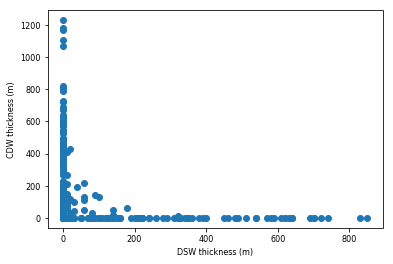

In [27]:
plt.scatter(waterMassThickness.DSW, waterMassThickness.CDW)
plt.xlabel("DSW thickness (m)")
plt.ylabel("CDW thickness (m)")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("./Images/waterMassBudgets/CDW_DSW_scatter.png", dpi=300)
plt.show()

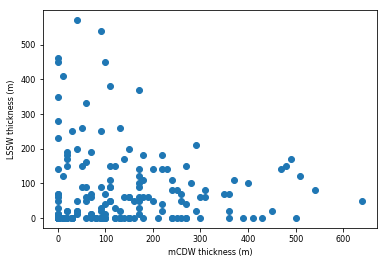

In [179]:
plt.scatter(waterMassThickness.mCDW, waterMassThickness.LSSW)
plt.xlabel("mCDW thickness (m)")
plt.ylabel("LSSW thickness (m)")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("./Images/waterMassBudgets/mCDW_LSSW_scatter.png", dpi=300)
plt.show()

In [31]:
dfmg.loc[Adelie & gline_le_75km, 'PSAL_ADJUSTED_ERROR'].describe()

count    71556.000000
mean         0.192919
std          0.031813
min          0.050000
25%          0.200000
50%          0.200000
75%          0.200000
max          0.200000
Name: PSAL_ADJUSTED_ERROR, dtype: float64

In [17]:
waterMassThickness.groupby('region').sum().sort_values('LSSW', ascending=True)

,CDW,DSW,ISW,LSSW,mCDW,month,zlowest
region,,,,,,,
ASA2,2960.0,0.0,40.0,0.0,0.0,78,-8661.365184
BSA1,5620.0,0.0,0.0,0.0,170.0,78,-11574.702811
BSA2,10070.0,0.0,0.0,0.0,30.0,78,-17373.434997
ASA1,3450.0,0.0,40.0,10.0,0.0,78,-10078.079820
ACA2,3920.0,0.0,0.0,40.0,450.0,78,-8779.038154
RSA2,30.0,4660.0,1330.0,40.0,360.0,78,-8210.847179
PHCA1,950.0,0.0,0.0,40.0,410.0,78,-4604.559896
PHCA2,2260.0,0.0,0.0,50.0,410.0,78,-6325.486098
RSA1,0.0,6590.0,1110.0,80.0,440.0,78,-9581.822714


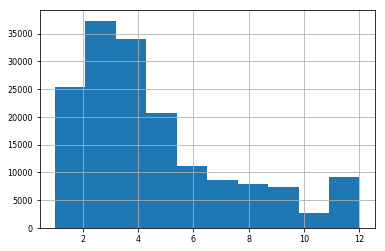

In [158]:
dfmg.loc[mCDW, 'JULD'].dt.month.hist()
plt.show()

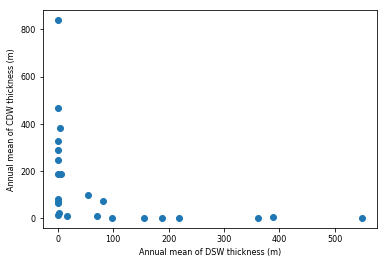

In [334]:
plt.scatter(waterMassThicknessMean.DSW, waterMassThicknessMean.CDW)
plt.xlabel("Annual mean of DSW thickness (m)")
plt.ylabel("Annual mean of CDW thickness (m)")
plt.show()

In [336]:
waterMassThickness.to_csv("waterMassThickness.csv")
waterMassThicknessMean.to_csv("waterMassThicknessMonthlyMean.csv")

In [325]:
np.corrcoef(waterMassThicknessSum.DSW, waterMassThicknessSum.CDW)

array([[ 1.        , -0.41669635],
       [-0.41669635,  1.        ]])

In [327]:
x = list(np.arange(10)) + [0]*10
y = [0]*10 + list(np.arange(10))
np.corrcoef(x,y)

array([[ 1.        , -0.55102041],
       [-0.55102041,  1.        ]])

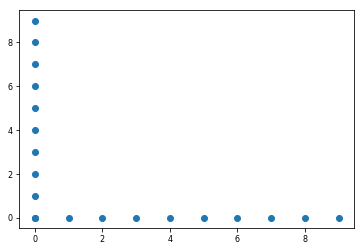

In [328]:
plt.scatter(x,y)
plt.show()

-1.7069259880483711


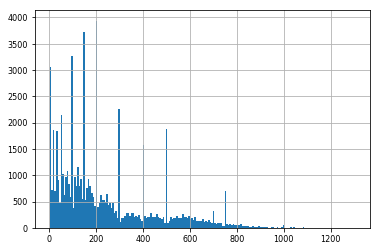

In [140]:
print(dfmg.loc[mCDW & gline_le_75km, 'CTEMP'].median())
dfmg.loc[mCDW & gline_le_75km, 'PRES_ADJUSTED'].hist(bins=200)

plt.show()

In [9]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman'],
      dtype='object')

In [14]:
print(dfmg.loc[DSW, 'POT_DENSITY'].mean(), dfmg.loc[CDW, 'POT_DENSITY'].mean())
print(dfmg.loc[DSW, 'gamman'].mean(), dfmg.loc[CDW, 'gamman'].mean())

27.8903786214613 27.7511179859141
28.552284189771893 28.018659961886325


In [76]:
def print_depths(regions=[], titles=[]):
    if regions:
        for i in range(len(regions)):
            print(titles[i], dfmg.loc[regions[i]].groupby('PROFILE_NUMBER').tail(1).DEPTH.quantile(0.01), 
                  dfmg.loc[regions[i]].DEPTH.min())

In [77]:
print_depths(regions1, titles1)

(a) WSA1 -823.3055655942601 -941.815692774
(b) CDA1 -788.1890783377459 -848.829808226
(c) EPBA1 -735.8564145271239 -1188.58166248
(d) WSA2 -681.7018695431359 -961.659849606
(e) CDA2 -1438.473017880955 -1678.25501111
(f) EPBA2 -944.2238366401219 -1415.01685951
(g) WPBA1 -819.7121170076961 -1338.03890632
(h) ACA1 -701.3615404056773 -950.332172173
(i) RSA1 -704.3102279690195 -1113.17124606
(j) WPBA2 -974.5357318179579 -1462.08841445
(k) ACA2 -996.3817697942225 -1291.1617639
(l) RSA2 -740.8271503005217 -953.734336501


In [58]:
def plot_salinity_density_histograms(df, salmin=33.5, salmax=36., wd=5, ht=3, sigmamin=27, sigmamax=29, 
                                     ymax=1e4, bins=100):
    plt.close(1)
    fig = plt.figure(1, figsize=(wd,ht))
    mrows, ncols = 1,2
    gs = gridspec.GridSpec(mrows, ncols, height_ratios=[1]*mrows, width_ratios=[1]*ncols)
    
    #plot salinity
    ax = plt.subplot(gs[0,0])
    df.PSAL_ADJUSTED.hist(ax=ax, bins=bins)
    ax.set_yscale('log')
    ax.set_xlim(salmin, salmax)
    ax.set_ylim(1e-1, ymax)
    
    #plot density
    ax = plt.subplot(gs[0,1])        
    df.POT_DENSITY.hist(ax=ax, bins=bins)
    ax.set_yscale('log')
    ax.set_xlim(sigmamin, sigmamax)
    ax.set_ylim(1e-1, ymax)
    ax.set_yticklabels([])
    ax.set_ylabel("")
    plt.show()

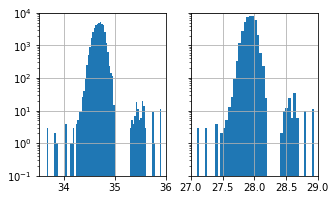

In [59]:
plot_salinity_density_histograms(dfmg.loc[Ross & deepMask250], salmax=36)

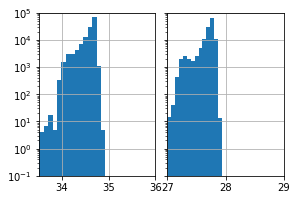

In [51]:
plot_salinity_density_histograms(dfmg.loc[(EBS | WBS) & deepMask250], ymax=1e5 , bins=300)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


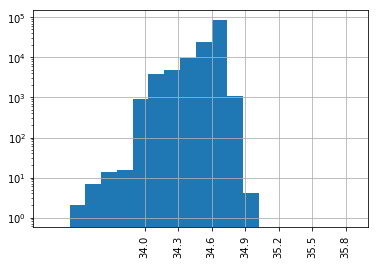

In [12]:
dfmg.loc[(WBS+EBS) & deepMask250, "PSAL_ADJUSTED"].hist(bins=200)
plt.yscale("log")
plt.xticks(np.arange(34, 36, 0.3), rotation=90)
plt.xlim(33, 36)
plt.show()

#### below 35 salinity water spans across all the latitudes, whereas above 35 is restricted to the southern most region

## PB A1

How much DSW ($\sigma_0 > 27.8$) is formed in A1 and how much in A2??

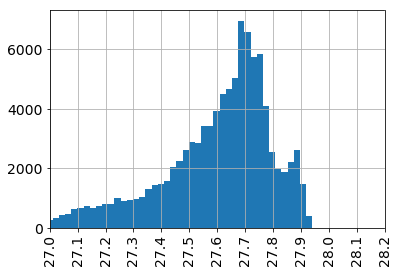

In [192]:
dfmg.loc[Prydz & gline_le_75km, "POT_DENSITY"].hist(bins=200)
plt.xticks(np.arange(26, 28.3, 0.1)[::1], rotation=90)
plt.xlim(27, 28.2)
plt.show()

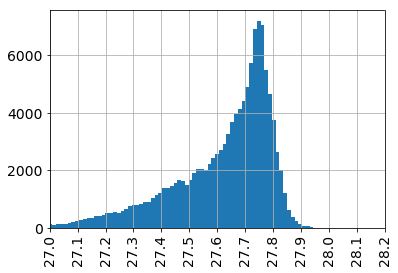

In [193]:
dfmg.loc[Prydz & ~gline_le_75km, "POT_DENSITY"].hist(bins=200)
plt.xticks(np.arange(26, 28.3, 0.1), rotation=90)
plt.xlim(27, 28.2)
plt.show()

## PB A2

## Western Prydz Bay

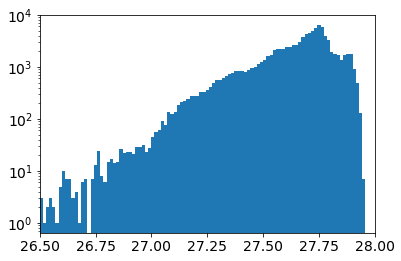

In [196]:
fig, ax = plt.subplots()
ax.hist(np.sort(dfmg.loc[WPB, 'POT_DENSITY'].dropna()), bins=300)
plt.yscale("log")
ax.set_xlim(26.5, 28)
plt.show()

## Eastern PB

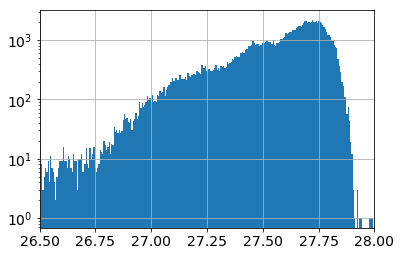

In [198]:
dfmg.loc[EPB, 'POT_DENSITY'].hist(bins=500)
plt.yscale("log")
plt.xlim(26.5, 28)
plt.show()

## Cape Darnley 

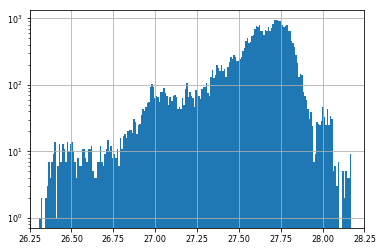

In [21]:
dfmg.loc[CDP, 'POT_DENSITY'].hist(bins=500)
plt.yscale("log")
plt.xlim(26.25, 28.25)
plt.show()

## Adelie Coast

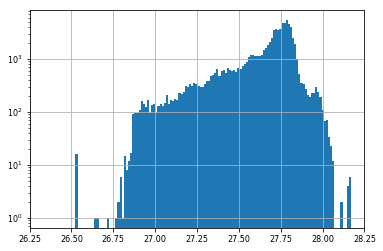

In [22]:
dfmg.loc[Adelie, 'POT_DENSITY'].hist(bins=500)
plt.yscale("log")
plt.xlim(26.25, 28.25)
plt.show()

## Knox Coast

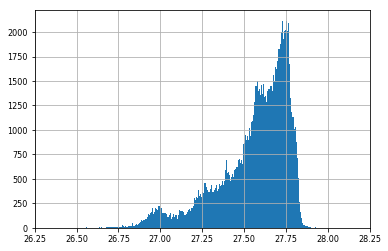

In [23]:
dfmg.loc[Knox, 'POT_DENSITY'].hist(bins=300)
plt.xlim(26.25, 28.25)
plt.show()

## Princess Martha Coast

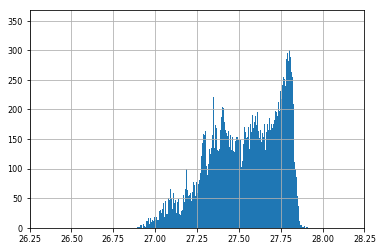

In [24]:
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37)
dfmg.loc[Harald, 'POT_DENSITY'].hist(bins=300)
plt.xlim(26.25, 28.25)
plt.show()

## Example of T-S plots: Leopold and Astrid Coast
Just East of Prydz Bay

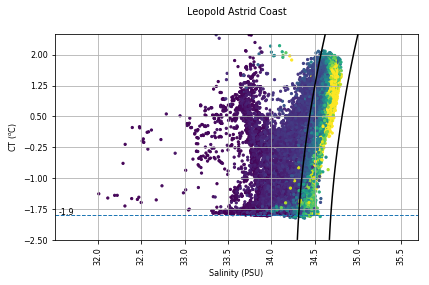

In [91]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
fig, ax = plt.subplots()
plot_theta_sal.plot_theta_s(ax, dfmg, LAC , thetamin=-2.5, thetamax=2.5, salmin=31.5, 
                            salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], 
                            theta_ticks=theta_ticks, sal_ticks=sal_ticks, title="Leopold Astrid Coast")
plt.show()

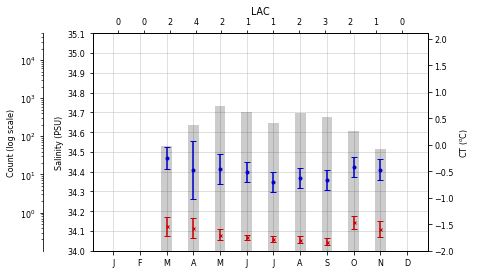

In [66]:
fig, ax = plt.subplots()
sal_ticks = list(np.arange(34., 35.1, 0.1))
theta_ticks = list(np.arange(-2., 2.1, 0.5))
pltsurfbot.plot_bottom_theta_sal_averages(ax, dfmg, LAC & gline_le_75km & deepMask250, title="LAC",
                                                     markersize=3, salmin=34.,
                                                     salmax=35.1, thetamin=-2, thetamax=2.1, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=False, fontsize=8, 
                                                      count_frame_on=True)
plt.show()

### Queen Mary Coast

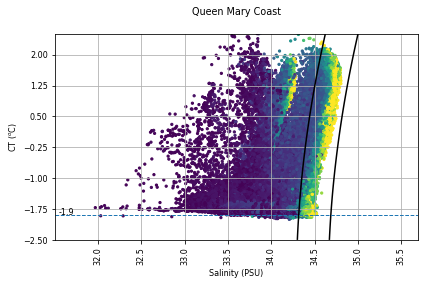

In [92]:
fig, ax = plt.subplots()
plot_theta_sal.plot_theta_s(ax, dfmg, QMC, thetamin=-2.5, thetamax=2.5, salmin=31.5, 
                            salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], 
                            theta_ticks=theta_ticks, sal_ticks=sal_ticks, title="Queen Mary Coast")
plt.show()

In [69]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

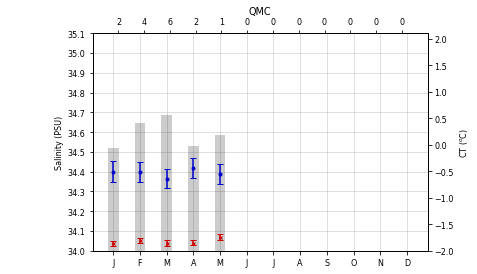

In [72]:
fig, ax = plt.subplots()
sal_ticks = list(np.arange(34., 35.1, 0.1))
theta_ticks = list(np.arange(-2., 2.1, 0.5))
pltsurfbot.plot_bottom_theta_sal_averages(ax, dfmg, QMC & gline_le_75km & deepMask250, title="QMC",
                                                     markersize=3, salmin=34,
                                                     salmax=35.1, thetamin=-2, thetamax=2.1, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=False, fontsize=8, 
                                                      count_frame_on=False)
plt.show()

## Harald Coast

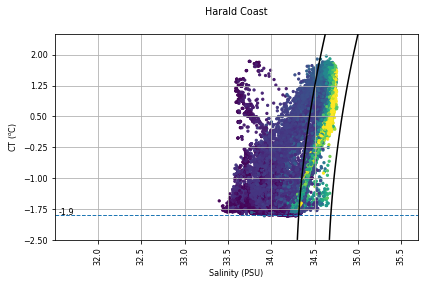

In [93]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
fig, ax = plt.subplots()
plot_theta_sal.plot_theta_s(ax, dfmg, Harald, thetamin=-2.5, thetamax=2.5, salmin=31.5, 
                            salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], 
                            theta_ticks=theta_ticks, sal_ticks=sal_ticks, title="Harald Coast")
plt.show()

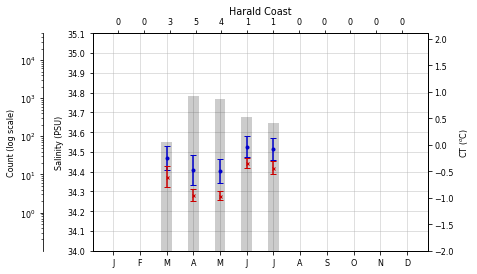

In [94]:
fig, ax = plt.subplots()
sal_ticks = list(np.arange(34., 35.1, 0.1))
theta_ticks = list(np.arange(-2., 2.1, 0.5))
pltsurfbot.plot_bottom_theta_sal_averages(ax, dfmg, Harald & gline_le_75km & deepMask250, title="Harald Coast",
                                                     markersize=3, salmin=34,
                                                     salmax=35.1, thetamin=-2, thetamax=2.1, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=False, fontsize=8, 
                                                      count_frame_on=True)
plt.show()

## Princess Martha Coast

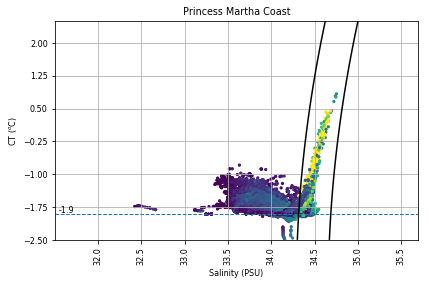

In [12]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
fig, ax = plt.subplots()
plot_theta_sal.plot_theta_s(ax, dfmg, PrincessMartha & gline_le_75km, thetamin=-2.5, thetamax=2.5, salmin=31.5, 
                            salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], 
                            theta_ticks=theta_ticks, sal_ticks=sal_ticks, title="Princess Martha Coast")
plt.show()

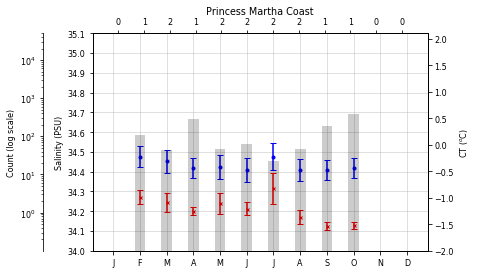

In [96]:
fig, ax = plt.subplots()
sal_ticks = list(np.arange(34., 35.1, 0.1))
theta_ticks = list(np.arange(-2., 2.1, 0.5))
pltsurfbot.plot_bottom_theta_sal_averages(ax, dfmg, PrincessMartha & gline_le_75km & deepMask500, 
                                          title="Princess Martha Coast", markersize=3, salmin=34,
                                                     salmax=35.1, thetamin=-2, thetamax=2.1, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=False, fontsize=8, 
                                                      count_frame_on=True)
plt.show()

In [137]:
def print_counts(regions=[], names=[]):
    for i in range(len(regions)):
        Nprof = len(dfmg.loc[regions[i], 'PROFILE_NUMBER'].unique())
        NprofSource = len(dfmg.loc[regions[i] & WSO_source, 'PROFILE_NUMBER'].unique())
        print(names[i], Nprof, NprofSource, NprofSource/Nprof)

In [138]:
regions = [Weddell, PrincessMartha, Harald, CDP, Prydz, LAC, QMC, Knox, Adelie, Ross, (AmundsenEast+AmundsenWest), 
          (EBS + WBS)]
names = ["WS", "PMC", "PHC", "CDP", "PB", "LAC", "QMC", "KC", "AC", "RS", "AS", "BS"]
print_counts(regions=regions, names=names)

WS 16405 3589 0.21877476379152697
PMC 4704 19 0.0040391156462585035
PHC 2386 5 0.0020955574182732607
CDP 2258 346 0.15323294951284322
PB 26267 4945 0.1882590322457837
LAC 2606 33 0.01266308518802763
QMC 3498 22 0.006289308176100629
KC 7761 47 0.0060559206287849505
AC 6196 1722 0.2779212395093609
RS 23054 14785 0.6413203782423874
AS 11931 2 0.0001676305422848043
BS 45721 2 4.3743575162398026e-05


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


# Creating array of water mass images

In [48]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]

Function which creates an array of T-S plots

In [49]:
def plot_waterMassFiguresInGrid(dfmg, regions, thetamin=[-2.5]*4, thetamax=[2]*4, salmin=[31.5]*4, mrows=3, ncols=3,
                           salmax=[35.7]*4, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], wd=10, ht=10, save=False,
                           savename="./Images/TSplots/watermass.png", theta_ticks=[theta_ticks]*4, titles=[],
                           sal_ticks=[sal_ticks]*4, show_legend=False, fontsize=8, colorbar_rowspan=[0,-1]):
    plt.close(1)
    fig = plt.figure(1, figsize=(wd,ht))
    gs = gridspec.GridSpec(mrows, ncols+2, height_ratios=[1]*mrows, width_ratios=[1]*ncols+[0.03,0.05])
    
    matplotlib.rcParams.update({'axes.titlepad':6})
    axarr = []
    counter = 0

    for i in range(mrows):
        for j in range(ncols):
            axarr.append(plt.subplot(gs[i,j]) ) # place it where it should be.
            #axarr.append(plt.subplot2grid((mrows+1, ncols), (i, j)  ))
            
            #print(counter)
            SC = plot_theta_sal.plot_theta_s(axarr[-1], dfmg, regions[counter], thetamin=thetamin[i], 
                                             thetamax=thetamax[i], salmin= salmin[i], salmax=salmax[i], 
                                             templine=templine, s=s, alpha=alpha, 
                                        sig_lines=sig_lines, theta_ticks= theta_ticks[i], sal_ticks=sal_ticks[i], 
                                        show_legend=show_legend, title=titles[counter], fontsize=fontsize)
            if(j > 0):
                axarr[-1].set_yticklabels([])
                axarr[-1].set_ylabel("")
                
            if(i != mrows-1):
                axarr[-1].set_xticklabels([])
                axarr[-1].set_xlabel("")
            if((i == mrows-1) and (j!=1)):
                axarr[-1].set_xlabel("")
                
            
            counter += 1
            if(counter == len(regions)):
                break
        if(counter == len(regions)):
            break
    
    cbax = plt.subplot(gs[colorbar_rowspan[0]:colorbar_rowspan[-1] , ncols+1]) # Place it where it should be.
    # --------------------------------------------------------
    cb = Colorbar(ax = cbax, mappable = SC, orientation = 'vertical', extend='max')
    cb.set_label(r'dbar', labelpad=5)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()

## Watermasses Fig. 1

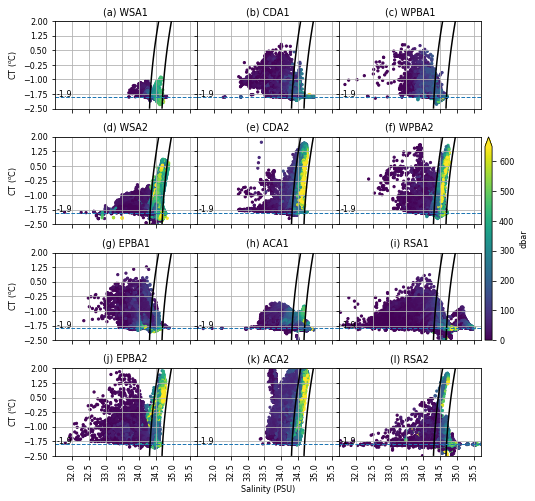

In [50]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
A1 = gline_le_75km
A2 = ~gline_le_75km
regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 
          
plot_waterMassFiguresInGrid(dfmg, regions1, titles=titles, theta_ticks=[theta_ticks]*4, sal_ticks=[sal_ticks]*4, 
                            thetamin=[-2.5]*4, thetamax=[2]*4, save=True, savename="./Images/TSplots/waterMass1.png", 
                            wd=7.48, ht=7, mrows=4, colorbar_rowspan=[1,3])

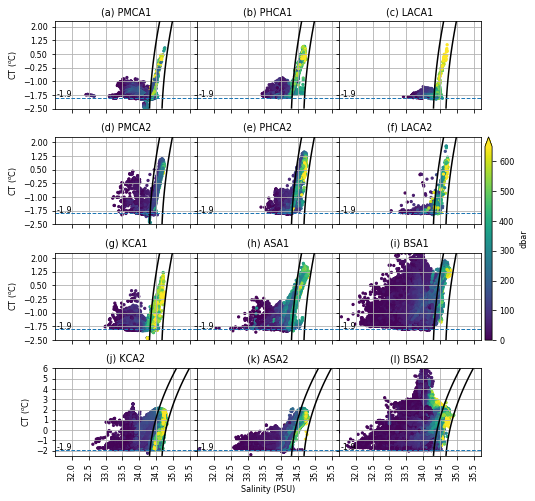

In [11]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
theta_ticks2 = list(np.arange(-2., 6.1, 1) )
A1 = gline_le_75km
A2 = ~gline_le_75km
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]
plot_waterMassFiguresInGrid(dfmg, regions2, titles=titles2, theta_ticks=[theta_ticks]*3+[theta_ticks2]*1, 
                            sal_ticks=[sal_ticks]*4, thetamin=[-2.5]*4,
                            thetamax=[2.3]*3+[6]*1, save=True, savename="./Images/TSplots/waterMass2.png", 
                            wd=7.48, ht=7., mrows=4, colorbar_rowspan=[1,3])

## mSW producing regions

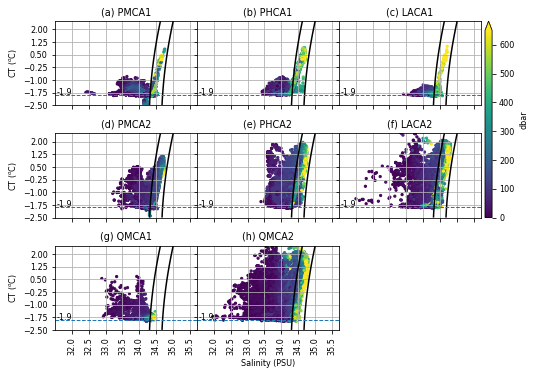

In [107]:
A1 = gline_le_75km
A2 = ~gline_le_75km
regions1 = [PrincessMartha & A1, Harald & A1, LAC & A1, PrincessMartha & A2, Harald & A2, LAC & A2, 
            QMC & A1, QMC & A2]
titles = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", "(d) PMCA2", "(e) PHCA2", "(f) LACA2", "(g) QMCA1", "(h) QMCA2"]
          
plot_waterMassFiguresInGrid(dfmg, regions1, titles=titles, theta_ticks=theta_ticks, sal_ticks=sal_ticks, thetamin=-2.5,
                            thetamax=2.5, save=True, savename="./Images/TSplots/waterMass3.png", 
                            wd=7.48, ht=5.25, mrows=3, colorbar_rowspan=[0,2])

In [71]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

# Surface Salinities, Group 1

In [57]:
import matplotlib
def plot_surfbotpropFiguresInGrid(dfmg, regions, titles=[], thetamin=-2.5, thetamax=2, salmin=31.5, mrows=3, ncols=3,
                           salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], wd=10, ht=10, save=False,
                           savename="./Images/surf_bot_prop/surfprop1.png", theta_ticks=[], 
                           sal_ticks=[], show_legend=False, fontsize=8, height_ratios=[],
                           func= pltsurfbot.plot_surface_theta_sal_averages, xlabels=[], rylabels=[], lylabels=[]):
    
    matplotlib.rcParams.update({'axes.titlepad':19, 'font.size':fontsize})
    fig = plt.figure(figsize=(wd,ht))
    axarr = []
    counter = 0
    if not height_ratios:
        height_ratios = [1]*mrows 
    gs = gridspec.GridSpec(mrows, ncols, height_ratios=height_ratios, width_ratios=[1]*ncols)
    
    for i in range(mrows):
        if(height_ratios[i] < 1):
            pass
        else:
            for j in range(ncols):
                axarr.append(plt.subplot(gs[i, j]) )

                #print(counter)
                if(j > 0):
                    count_frame_on = False
                else:
                    count_frame_on=True
                theta_ax, salcount_ax, countax = func(axarr[-1], dfmg, regions[counter], title=titles[counter],
                                                     markersize=3, salmin=salmin,
                                                     salmax=salmax, thetamin=thetamin, thetamax=thetamax, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=show_legend, fontsize=fontsize, 
                                                      count_frame_on=count_frame_on)
                if(j > 0):
                    axarr[-1].set_yticklabels([])
                    axarr[-1].set_ylabel("")
                    countax.set_ylim(1e-1, 5e4)
                    countax.set_axis_off()
                if((j < ncols-1) and (counter < len(regions)-1)):
                    #theta_ax.set_yticklabels([])
                    #theta_ax.set_ylabel("")
                    theta_ax.set_axis_off()
                if(i == 1 or i==4 or i==5):
                    pass
                else:
                    axarr[-1].set_xticklabels([])
                    axarr[-1].set_xlabel("")
                ## uncomment the following just for supplementary bottom figures
                #if(i == mrows-1 and j==0):
                #    theta_ax.set_yticklabels([])
                #    theta_ax.set_ylabel("")

                counter += 1
                if(counter == len(regions)):
                    break
        if(counter == len(regions)):
            break
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.7)
    
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()


In [40]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

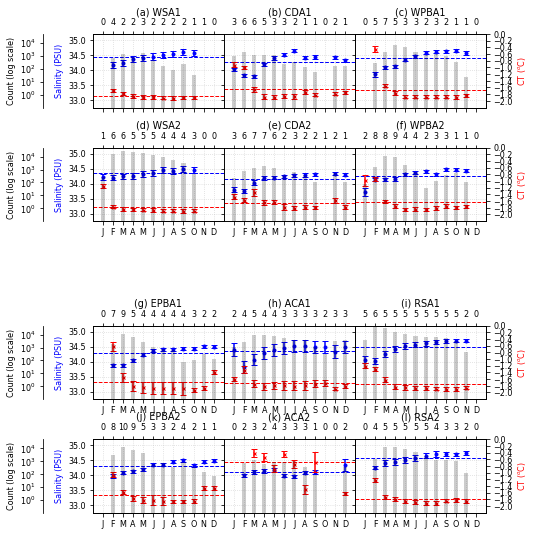

In [73]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 0.1, 0.2))
A1 = gline_le_75km
A2 = ~gline_le_75km

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 

plot_surfbotpropFiguresInGrid(dfmg, regions1, titles=titles1, func = pltsurfbot.plot_surface_theta_sal_averages,
                              thetamin=-2.2, thetamax=0, salmin=32.75, salmax=35.2, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/surfprop1.png")

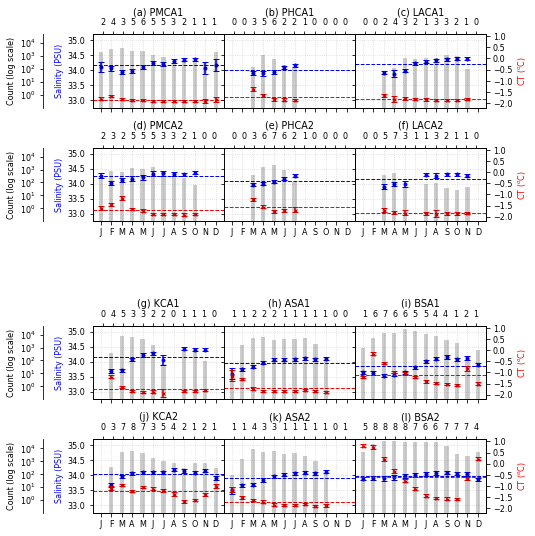

In [535]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 1.1, 0.5))
A1 = gline_le_75km
A2 = ~gline_le_75km

regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions2, titles=titles2, thetamin=-2.2, thetamax=1.1, salmin=32.75, salmax=35.2, 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              save = True, savename="./Images/surf_bot_prop/surfprop2.png")

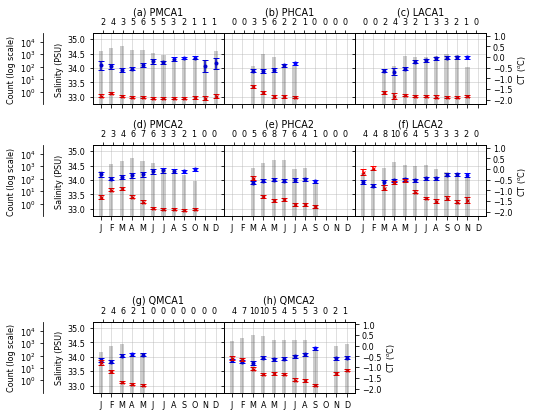

In [118]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 1.1, 0.5))
A1 = gline_le_75km
A2 = ~gline_le_75km

regions3 = [PrincessMartha & A1, Harald & A1, LAC & A1, PrincessMartha & A2, Harald & A2, LAC & A2, 
            QMC & A1, QMC & A2]
titles3 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", "(d) PMCA2", "(e) PHCA2", "(f) LACA2", "(g) QMCA1", "(h) QMCA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions3, titles=titles3, thetamin=-2.2, thetamax=1.1, salmin=32.75, salmax=35.2, 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=4, ncols=3, wd=7.48, ht=5.82925, 
                              height_ratios=[1,1, 0.331, 1],
                             save = True, savename="./Images/surf_bot_prop/surfprop3.png")

# Bottom Salinities array of figures

In [528]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

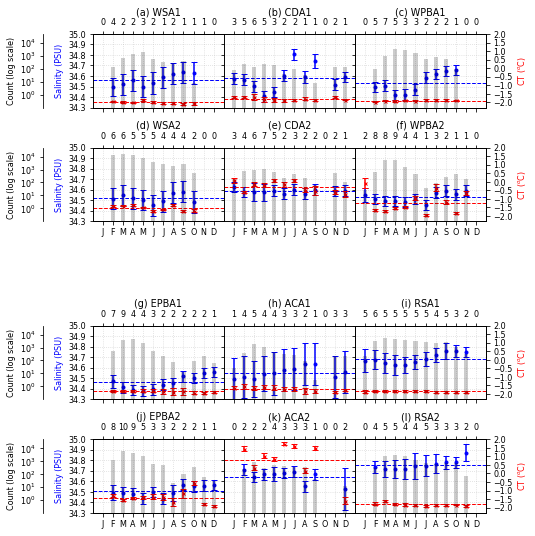

In [58]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250
B2 = ~gline_le_75km & deepMask250

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

titles = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop1_250.png")

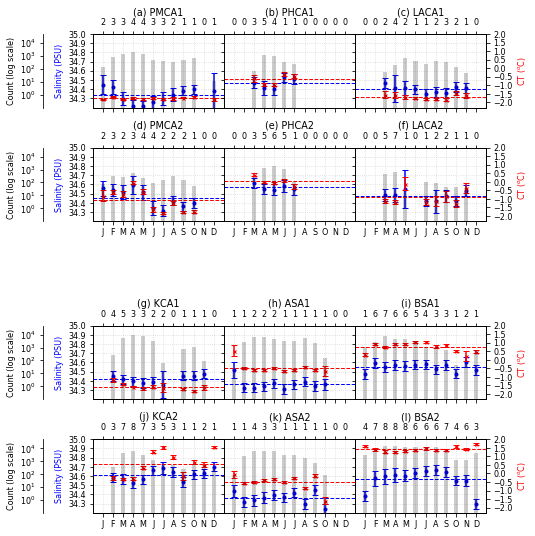

In [59]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250
B2 = ~gline_le_75km & deepMask250
B1_500 = gline_le_75km & deepMask500
B2_500 = ~gline_le_75km & deepMask500

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop2_250.png")

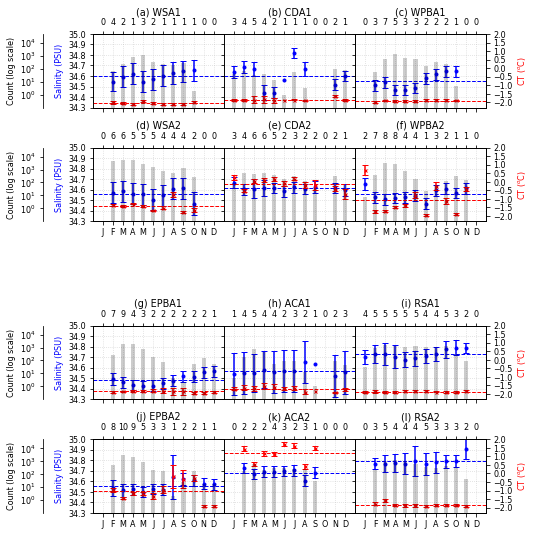

In [60]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375
B2 = ~gline_le_75km & deepMask375

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

titles = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop1_375.png")

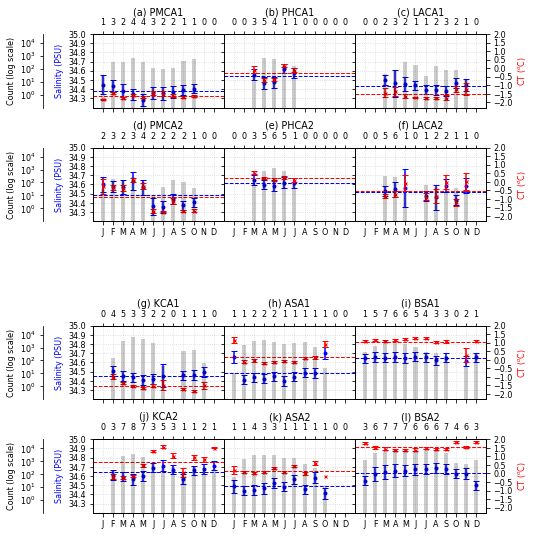

In [61]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375
B2 = ~gline_le_75km & deepMask375

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop2_375.png")

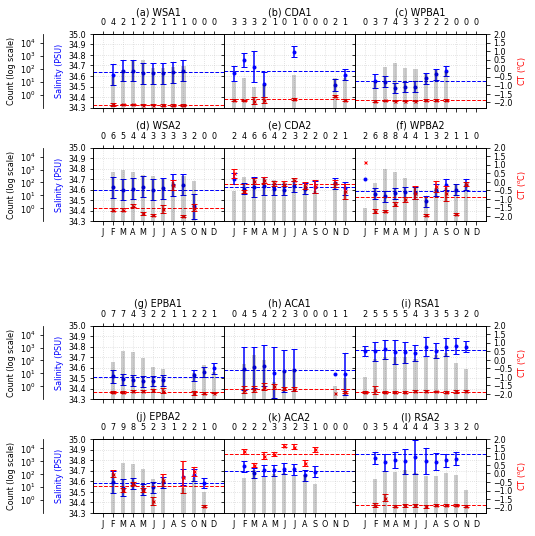

In [62]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500
B2 = ~gline_le_75km & deepMask500

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

titles = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop1_500.png")

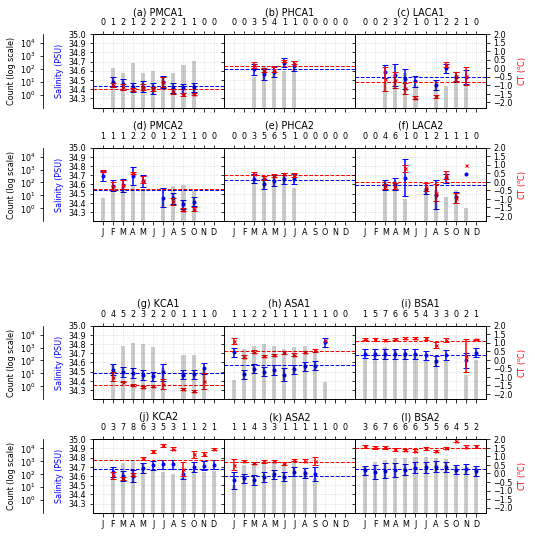

In [63]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500
B2 = ~gline_le_75km & deepMask500

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop/botprop2_500.png")

## mSW producing regions

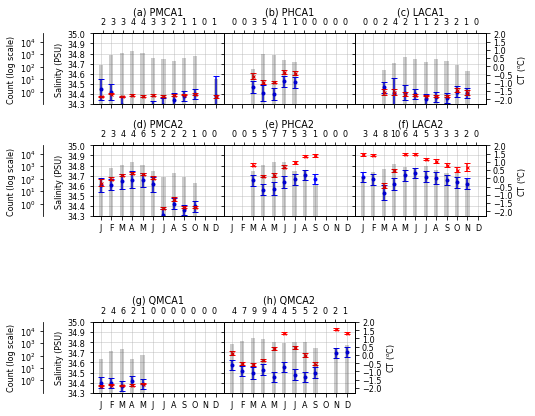

In [119]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250
B2 = ~gline_le_75km & deepMask250


regions3bot = [PrincessMartha & B1, Harald & B1, LAC & B1, PrincessMartha & B2, Harald & B2, LAC & B2, 
            QMC & B1, QMC & B2]
titles3 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", "(d) PMCA2", "(e) PHCA2", "(f) LACA2", "(g) QMCA1", "(h) QMCA2"]

plot_surfbotpropFiguresInGrid(dfmg, regions3bot, titles=titles3, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=4, ncols=3, wd=7.48, ht=5.82925, 
                             save = True, savename="./Images/surf_bot_prop/botprop3.png", height_ratios=[1,1, 0.331, 1])

In [120]:
len(dfmg.loc[Knox & WSO_source, 'PROFILE_NUMBER'].unique())

47

## Supplementary figures for group1 regions

In [57]:
9/5*6

10.8

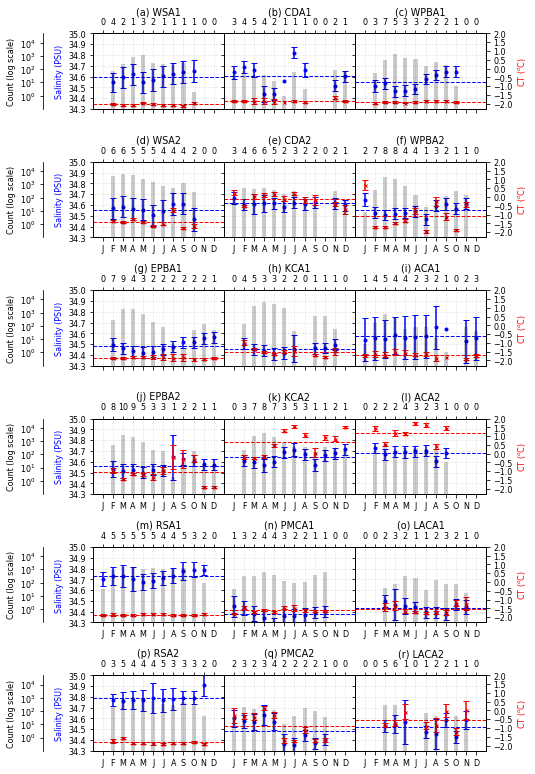

In [61]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375
B2 = ~gline_le_75km & deepMask375

regionsSup = [Weddell&B1, CDP&B1,    WPB & B1, 
               Weddell&B2, CDP&B2,    WPB & B2, 
               EPB&B1,     Knox&B1,   Adelie & B1, 
               EPB & B2,   Knox & B2, Adelie& B2, 
               Ross & B1,  PrincessMartha & B1, LAC & B1,
               Ross & B2,  PrincessMartha & B2, LAC & B2]

titlesSup = ["(a) WSA1", "(b) CDA1", "(c) WPBA1", "(d) WSA2", "(e) CDA2", "(f) WPBA2", "(g) EPBA1", "(h) KCA1", 
          "(i) ACA1", "(j) EPBA2", "(k) KCA2", "(l) ACA2", "(m) RSA1", "(n) PMCA1", "(o) LACA1", "(p) RSA2", 
            "(q) PMCA2", "(r) LACA2"] 

plot_surfbotpropFiguresInGrid(dfmg, regionsSup, titles=titlesSup, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=10.8, 
                              save = True, savename="./Images/surf_bot_prop/botprop1_375.png")

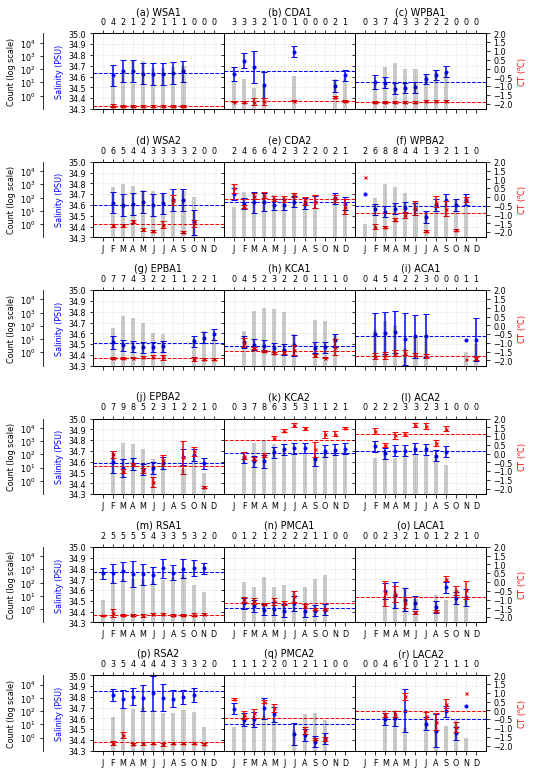

In [62]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500
B2 = ~gline_le_75km & deepMask500

regionsSup = [Weddell&B1, CDP&B1,    WPB & B1, 
               Weddell&B2, CDP&B2,    WPB & B2, 
               EPB&B1,     Knox&B1,   Adelie & B1, 
               EPB & B2,   Knox & B2, Adelie& B2, 
               Ross & B1,  PrincessMartha & B1, LAC & B1,
               Ross & B2,  PrincessMartha & B2, LAC & B2]

titlesSup = ["(a) WSA1", "(b) CDA1", "(c) WPBA1", "(d) WSA2", "(e) CDA2", "(f) WPBA2", "(g) EPBA1", "(h) KCA1", 
          "(i) ACA1", "(j) EPBA2", "(k) KCA2", "(l) ACA2", "(m) RSA1", "(n) PMCA1", "(o) LACA1", "(p) RSA2", 
            "(q) PMCA2", "(r) LACA2"] 

plot_surfbotpropFiguresInGrid(dfmg, regionsSup, titles=titlesSup, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=10.8, 
                              save = True, savename="./Images/surf_bot_prop/botprop1_500.png")

### L2 norm between bottom depths 
L2 norm here is calculated as : $$\Large \text{L2 norm of }\Phi_{(375m-250m)} = \sqrt{ \frac{\sum_{i=1}^{i=12} (\Phi_{250_i} - \Phi_{375_i})^2}{12} } $$

Where $i$ ranges over the months

In [100]:
def botPropertiesL2Norm(df, region=[]):
    if not region:
        print("Error!! Region cannot be empty!!!")
        return 0
    depthMask250 = df.DEPTH <= -250
    depthMask375 = df.DEPTH <= -375
    depthMask500 = df.DEPTH <= -500
    
    salL2_375 = np.zeros(len(region))
    salL2_500 = np.zeros(len(region))
    thetaL2_375 = np.zeros(len(region))
    thetaL2_500 = np.zeros(len(region))
    salstd250, thetastd250 = np.zeros(len(region)), np.zeros(len(region))
    salstd375, thetastd375 = np.zeros(len(region)), np.zeros(len(region))
    salstd500, thetastd500 = np.zeros(len(region)), np.zeros(len(region))
    
    for i in range(len(region)):
        for area in range(2):
            salmean250 = np.array([np.nan]*12)
            salmean375 = np.array([np.nan]*12)
            salmean500 = np.array([np.nan]*12)
            thetamean250 = np.array([np.nan]*12)
            thetamean375 = np.array([np.nan]*12)
            thetamean500 = np.array([np.nan]*12)
        
        for month in range(12):
            monthMask = df.JULD.dt.month == month+1
                            
            salmean250[month] = df.loc[region[i] & monthMask & depthMask250, "PSAL_ADJUSTED"].mean()
            salmean375[month] = df.loc[region[i] & monthMask & depthMask375, "PSAL_ADJUSTED"].mean()
            salmean500[month] = df.loc[region[i] & monthMask & depthMask500, "PSAL_ADJUSTED"].mean()
                        
            thetamean250[month] = df.loc[region[i] & monthMask & depthMask250, "CTEMP"].mean()
            thetamean375[month] = df.loc[region[i] & monthMask & depthMask375, "CTEMP"].mean()
            thetamean500[month] = df.loc[region[i] & monthMask & depthMask500, "CTEMP"].mean()
            
        salstd250[i] = df.loc[region[i] & depthMask250, "PSAL_ADJUSTED"].std()    
        salstd375[i] = df.loc[region[i] & depthMask375, "PSAL_ADJUSTED"].std()
        salstd500[i] = df.loc[region[i] & depthMask500, "PSAL_ADJUSTED"].std()
        thetastd250[i] = df.loc[region[i] & depthMask250, "CTEMP"].std()
        thetastd375[i] = df.loc[region[i] & depthMask375, "CTEMP"].std()
        thetastd500[i] = df.loc[region[i] & depthMask500, "CTEMP"].std()
        
        salL2_375[i] = np.sqrt(np.nanmean((salmean250 - salmean375)**2)) #/ salstd250
        #salL2_375[i] = (np.sqrt(np.nansum((salmean250 - salmean375)**2))) #WRONG!!!!!!
        
        salL2_500[i] = np.sqrt(np.nanmean((salmean250 - salmean500)**2 )) #/ salstd250
        #salL2_500[i] = (np.sqrt(np.nansum((salmean250 - salmean500)**2 ))) #WRONG!!!!!!
        
        thetaL2_375[i] = np.sqrt(np.nanmean((thetamean250 - thetamean375)**2 )) #/ thetastd250
        #thetaL2_375[i] = (np.sqrt(np.nansum((thetamean250 - thetamean375)**2 ))) #WRONG!!!!!!!!
        
        thetaL2_500[i] = np.sqrt(np.nanmean((thetamean250 - thetamean500)**2 )) #/ thetastd250
        #thetaL2_500[i] = (np.sqrt(np.nansum((thetamean250 - thetamean500)**2 ))) #WRONG!!!!!!!
    
    return salL2_375, salL2_500, thetaL2_375, thetaL2_500, [salstd250, salstd375, salstd500, thetastd250, \
            thetastd375, thetastd500]

In [101]:
A1 = gline_le_75km
A2 = ~gline_le_75km

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

salL2_375, salL2_500, thetaL2_375, thetaL2_500, stds = botPropertiesL2Norm(dfmg, region=regions1+regions2)

In [105]:
stds[6]

IndexError: list index out of range

In [123]:
regions_list = titles1 + titles2
for i in range(len(regions_list)):
    print(regions_list[i], '{:0.2f}'.format(stds[0][i]), 
                                    '{:0.2f}'.format(salL2_375[i])+'({:0.2f}'.format(stds[1][i])+")", 
                                    '{:0.2f}'.format(salL2_500[i])+"({:0.2f}".format(stds[2][i])+")",  
                                    '{:0.2f}'.format(stds[3][i]),
                                    '{:0.2f}'.format(thetaL2_375[i])+"({:0.2f}".format(stds[4][i])+")",  
                                    '{:0.2f}'.format(thetaL2_500[i])+"({:0.2f}".format(stds[5][i])+")")

(a) WSA1 0.10 0.04(0.08) 0.09(0.03) 0.20 0.07(0.22) 0.15(0.07)
(b) CDA1 0.14 0.07(0.14) 0.11(0.14) 0.17 0.09(0.12) 0.13(0.11)
(c) WPBA1 0.10 0.03(0.07) 0.04(0.06) 0.07 0.02(0.06) 0.01(0.06)
(d) WSA2 0.11 0.04(0.10) 0.10(0.10) 0.60 0.22(0.66) 0.45(0.70)
(e) CDA2 0.09 0.03(0.08) 0.05(0.07) 0.99 0.19(0.94) 0.26(0.85)
(f) WPBA2 0.07 0.04(0.07) 0.07(0.07) 0.75 0.25(0.83) 0.47(0.95)
(g) EPBA1 0.10 0.03(0.08) 0.06(0.06) 0.10 0.02(0.07) 0.04(0.06)
(h) ACA1 0.08 0.03(0.06) 0.06(0.04) 0.20 0.05(0.22) 0.09(0.16)
(i) RSA1 0.10 0.05(0.09) 0.09(0.10) 0.17 0.03(0.22) 0.05(0.35)
(j) EPBA2 0.10 0.06(0.10) 0.09(0.11) 0.75 0.56(0.93) 0.77(1.06)
(k) ACA2 0.09 0.03(0.07) 0.05(0.05) 0.97 0.16(0.75) 0.20(0.64)
(l) RSA2 0.11 0.04(0.10) 0.16(0.11) 0.41 0.03(0.45) 0.08(0.49)
(a) PMCA1 0.14 0.06(0.10) 0.14(0.08) 0.31 0.17(0.43) 0.59(0.53)
(b) PHCA1 0.16 0.08(0.13) 0.16(0.10) 0.79 0.39(0.73) 0.81(0.50)
(c) LACA1 0.07 0.04(0.07) 0.14(0.09) 0.33 0.18(0.47) 1.02(0.93)
(d) PMCA2 0.17 0.04(0.16) 0.09(0.14) 1.14 0.25(1

In [ ]:
salL2_375, salL2_500, thetaL2_375, thetaL2_500 = botPropertiesL2Norm(dfmg, region=[Weddell & gline_le_75km, 
Weddell & ~gline_le_75km, Ross & gline_le_75km, Ross & ~gline_le_75km, WPB & gline_le_75km, WPB & ~gline_le_75km, 
Adelie & gline_le_75km, Adelie & ~gline_le_75km, CDP & gline_le_75km, CDP & ~gline_le_75km, Knox & gline_le_75km, 
Knox & ~gline_le_75km, (AmundsenEast+AmundsenWest) & gline_le_75km, (AmundsenEast + AmundsenWest) & ~gline_le_75km, 
(WBS+EBS) & gline_le_75km, (WBS + EBS) & ~gline_le_75km, ])

In [42]:
regions_list = ["WSA1", "WSA2", "RSA1","RSA2", "WPBA1", "WPBA2", "ACA1", "ACA2", 
                                   "CDA1","CDA2", "KCA1","KCA2", "ASA1","ASA2", "BSA1", "BSA2"]
for i in range(len(regions_list)):
    print(regions_list[i], salL2_375[i], salL2_500[i], thetaL2_375[i], thetaL2_500[i], "\n")

WSA1 0.441415843755 0.950352986609 0.340926013762 0.755783249804 

WSA2 0.421005113879 0.92758434716 0.362466494452 0.738088571573 

RSA1 0.480818799309 0.920043529187 0.188994950071 0.280277516749 

RSA2 0.335966735001 1.47169615209 0.0677130635052 0.185929518817 

WPBA1 0.268996301428 0.449901551935 0.26653110038 0.207259165497 

WPBA2 0.51439790766 0.95376109324 0.33257558996 0.621051857063 

ACA1 0.366560092929 0.698138715643 0.239747165707 0.447252917568 

ACA2 0.300088919257 0.54321342643 0.168180703408 0.21107963261 

CDA1 0.532729874111 0.792184704366 0.544898067698 0.749427401914 

CDA2 0.334503357218 0.522542392649 0.190236540387 0.261496905674 

KCA1 0.480919221208 0.805699343572 0.259221908435 0.466993995828 

KCA2 0.232578009321 0.510320447992 0.125911256164 0.274345596066 

ASA1 0.657840267867 0.991782641037 0.752670234529 1.09499608906 

ASA2 0.648751383905 1.16532728921 0.692169510735 1.02824623186 

BSA1 0.72261873828 0.958997284135 0.656261302073 0.74126927398 

BSA2 

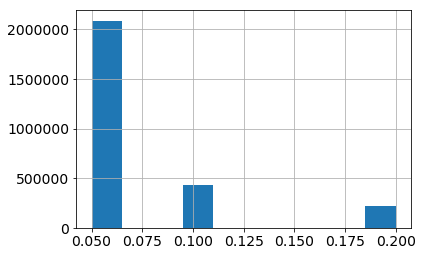

In [22]:
dfmg.PSAL_ADJUSTED_ERROR.hist()
plt.show()

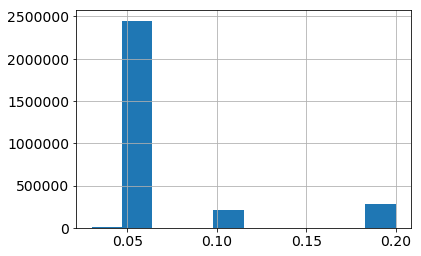

In [23]:
dfmg.TEMP_ADJUSTED_ERROR.hist()
plt.show()

#### Year-wise $\theta$-S plots

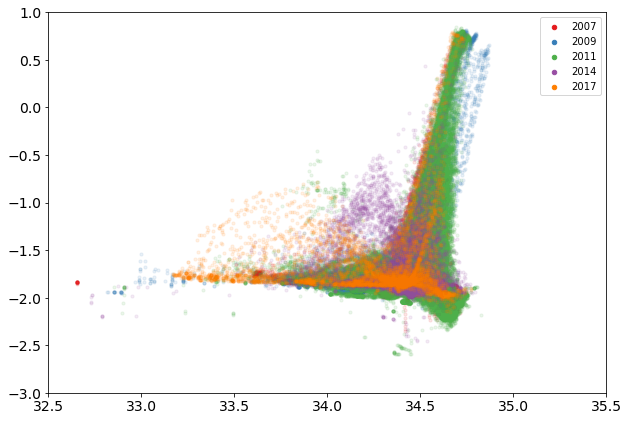

In [709]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Weddell, years=[2007, 2009, 2011, 2014, 2017], alpha=0.1, s=10, wd=10, ht=7)

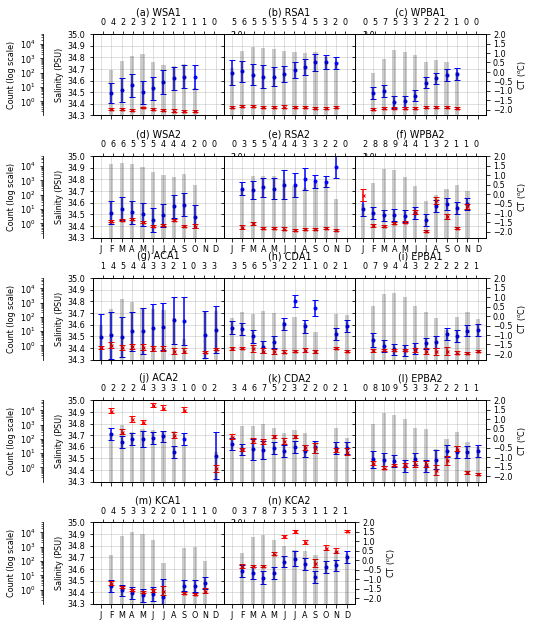

In [70]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250
RSB1 = gline_le_100km & deepMask250
B2 = ~gline_le_75km & deepMask250
RSB2 = ~gline_le_100km & deepMask250

regions1bot = [Weddell & B1, Ross & RSB1, WPB & B1, Weddell & B2, Ross & RSB2, WPB & B2, Adelie & B1, CDP&B1, EPB&B1, 
            Adelie& B2, CDP & B2, EPB & B2, Knox & B1, Knox & B2]
titles1 = ["(a) WSA1", "(b) RSA1", "(c) WPBA1", "(d) WSA2", "(e) RSA2", "(f) WPBA2", "(g) ACA1", "(h) CDA1", 
          "(i) EPBA1", "(j) ACA2", "(k) CDA2", "(l) EPBA2", "(m) KCA1", "(n) KCA2"] 

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=5, ncols=3, wd=7.48, ht=8.75, 
                              save = True, savename="./Images/surf_bot_prop/botprop1_250_RS100.png")

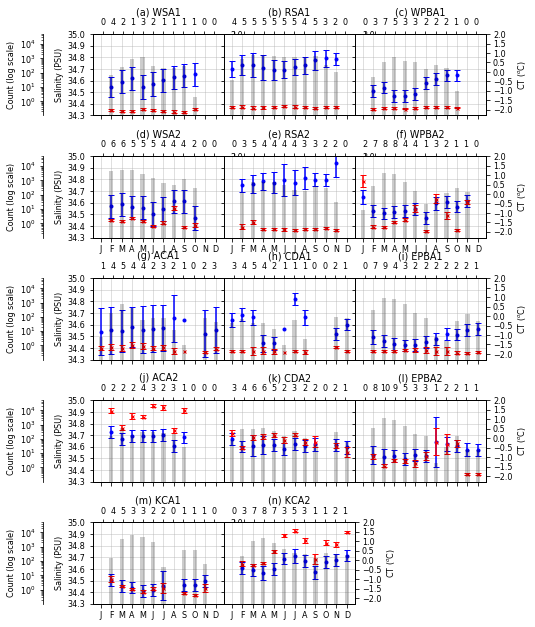

In [67]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375
RSB1 = gline_le_100km & deepMask375
B2 = ~gline_le_75km & deepMask375
RSB2 = ~gline_le_100km & deepMask375

regions1bot = [Weddell & B1, Ross & RSB1, WPB & B1, Weddell & B2, Ross & RSB2, WPB & B2, Adelie & B1, CDP&B1, EPB&B1, 
            Adelie& B2, CDP & B2, EPB & B2, Knox & B1, Knox & B2]
titles1 = ["(a) WSA1", "(b) RSA1", "(c) WPBA1", "(d) WSA2", "(e) RSA2", "(f) WPBA2", "(g) ACA1", "(h) CDA1", 
          "(i) EPBA1", "(j) ACA2", "(k) CDA2", "(l) EPBA2", "(m) KCA1", "(n) KCA2"] 

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=5, ncols=3, wd=7.48, ht=8.75, 
                              save = True, savename="./Images/surf_bot_prop/botprop1_375_RS100.png")

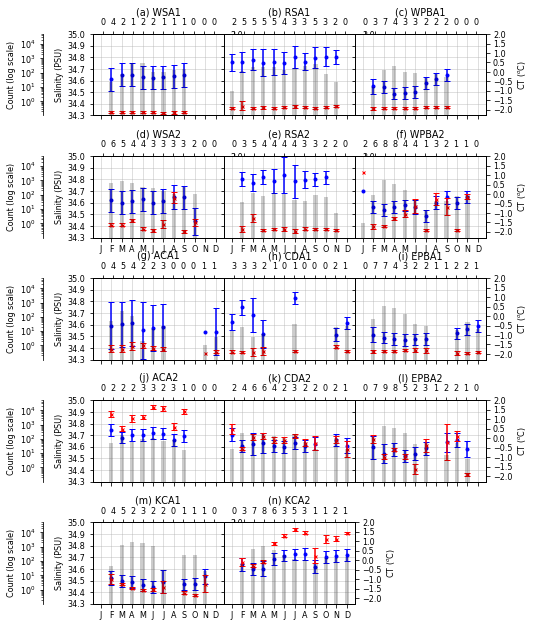

In [68]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500
RSB1 = gline_le_100km & deepMask500
B2 = ~gline_le_75km & deepMask500
RSB2 = ~gline_le_100km & deepMask500

regions1bot = [Weddell & B1, Ross & RSB1, WPB & B1, Weddell & B2, Ross & RSB2, WPB & B2, Adelie & B1, CDP&B1, EPB&B1, 
            Adelie& B2, CDP & B2, EPB & B2, Knox & B1, Knox & B2]
titles1 = ["(a) WSA1", "(b) RSA1", "(c) WPBA1", "(d) WSA2", "(e) RSA2", "(f) WPBA2", "(g) ACA1", "(h) CDA1", 
          "(i) EPBA1", "(j) ACA2", "(k) CDA2", "(l) EPBA2", "(m) KCA1", "(n) KCA2"] 

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=5, ncols=3, wd=7.48, ht=8.75, 
                              save = True, savename="./Images/surf_bot_prop/botprop1_500_RS100.png")

## CDW locations around Antarctica

Location of profiles detecting CDW

In [37]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [38]:
CDW = (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP > 0)

In [39]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

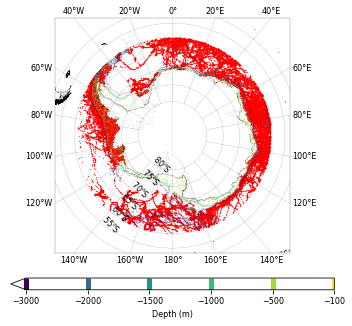

In [78]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/CDWpositions.png")

In [101]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Weddell",
                              save=True, savename="./Images/dataDensity/WS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5659861x5523520 pixels is too large. It must be less than 2^16 in each direction.

In [102]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Ross",
                              save=True, savename="./Images/dataDensity/RS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8719894x9170325 pixels is too large. It must be less than 2^16 in each direction.

In [42]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Knox", plotBathy=True,
                              save=True, savename="./Images/dataDensity/KC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722182x5929885 pixels is too large. It must be less than 2^16 in each direction.

In [99]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/AC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969746x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [52]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [53]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Prydz",
                              save=True, savename="./Images/dataDensity/CD_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8467006x5464788 pixels is too large. It must be less than 2^16 in each direction.

In [103]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Amundsen",
                              save=True, savename="./Images/dataDensity/AS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5817855x9535680 pixels is too large. It must be less than 2^16 in each direction.

In [104]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Belingshausen",
                              save=True, savename="./Images/dataDensity/BS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5368344x7915358 pixels is too large. It must be less than 2^16 in each direction.

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


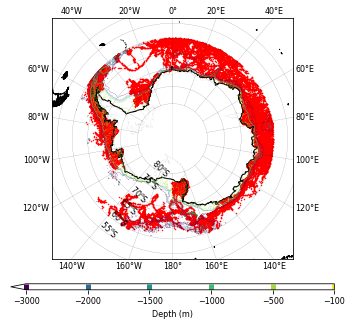

In [11]:
mCDWpositions = dfmg.loc[mCDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(mCDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/mCDWpositions.png")

In [10]:
def return_CT_mean_formalError(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = float(df.loc[mask, var].count())
    print("count", CTcount, "sd", CTsd)
    error1 = CTerrorMean 
    error2 = (1.96 * CTsd / np.sqrt(CTcount))
    error3 = np.sqrt(error1**2 + error2**2)
    
    return round(CTmean,2) , error1, CTsd, error2, error3

In [25]:
return_CT_mean_formalError(dfmg, Prydz & gline_le_75km & deepMask250 & sel_months(dfmg, [9]), var="PSAL_ADJUSTED" )

count 595.0 sd 0.027785509181720895


(34.64,
 0.05000000074505806,
 0.027785509181720895,
 0.0022326258474338815,
 0.05004982210438351)

In [64]:
def return_CT_mean(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = df.loc[mask, var].count()
    
    error = np.sqrt(CTerrorMean**2 + (1.96 * CTsd / np.sqrt(CTcount))**2)
    
    return round(CTmean,2) , error

In [72]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250)

(-1.75, 0.046551529449024444)

In [73]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250, var="PSAL_ADJUSTED")

(34.3, 0.063763968423933781)

In [13]:
return_CT_mean(dfmg, LAC & gline_le_75km & deepMask500)

(-0.88, 0.20277397804359704)

In [14]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask500)

(-1.49, 0.05407613216137537)

In [15]:
return_CT_mean(dfmg, CDP & gline_le_75km & deepMask500)

(-1.81, 0.14933881212951569)

In [16]:
return_CT_mean(dfmg, Adelie & gline_le_75km & deepMask500)

(-1.68, 0.18084063349163926)

In [51]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask500)

(-1.34, 0.058341226743662954)

In [52]:
return_CT_mean(dfmg, LAC & gline_le_75km & deepMask500)

(-0.88, 0.20277397804359704)

In [53]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask500)

(-1.49, 0.05407613216137537)

In [54]:
return_CT_mean(dfmg, CDP & gline_le_75km & deepMask500)

(-1.81, 0.14933881212951569)

In [55]:
return_CT_mean(dfmg, Adelie & gline_le_75km & deepMask500)

(-1.68, 0.18084063349163926)

In [52]:
return_CT_mean(dfmg, sel_months(dfmg, [1,2,3,4,5]) & Adelie & gline_le_75km & deepMask250)

(-1.63, 0.13759730183817886)

In [62]:
round(0.08009, 2)

0.08

In [19]:
April = sel_months(dfmg, [4])
return_CT_mean(dfmg, CDP & April & gline_le_75km & deepMask250, var='PSAL_ADJUSTED')

(34.41, 0.050000689586124296)

In [22]:
return_CT_mean(dfmg, AmundsenEast & surfaceWaters & sel_months(dfmg, [7,8,9]) )

(-1.82, 0.050000001284626956)

In [25]:
return_CT_mean(dfmg, Knox & gline_le_75km & surfaceWaters & sel_months(dfmg, [2]))

(-1.16, 0.050004584701687622)

In [28]:
return_CT_mean(dfmg, Knox & gline_le_75km & surfaceWaters & sel_months(dfmg, [2]), var='PSAL_ADJUSTED')

(33.64, 0.050002158711635866)

In [26]:
return_CT_mean(dfmg, Harald & gline_le_75km & surfaceWaters & sel_months(dfmg, [3]))

(-1.37, 0.050018335568185579)

In [27]:
return_CT_mean(dfmg, BS & gline_le_75km & surfaceWaters & sel_months(dfmg, [2]))

(-0.09, 0.05354136184047651)

In [31]:
return_CT_mean(dfmg, (AmundsenEast+AmundsenWest) & gline_le_75km & surfaceWaters & sel_months(dfmg, [8]), 
               var='PSAL_ADJUSTED' )

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


(34.12, 0.050000001671045124)

In [32]:
return_CT_mean(dfmg, (EBS+WBS) & gline_le_75km & surfaceWaters & sel_months(dfmg, [9]), 
               var='PSAL_ADJUSTED' )

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


(34.15, 0.050000004708503749)

In [90]:
return_CT_mean(dfmg, Amundsen & gline_le_75km & deepMask500)

(0.35, 0.052746463356250543)

In [89]:
return_CT_mean(dfmg, Amundsen & gline_le_75km & deepMask500, var='PSAL_ADJUSTED')

(34.52, 0.050287452672318468)

In [91]:
return_CT_mean(dfmg, (EBS+WBS) & gline_le_75km & deepMask500)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


(1.18, 0.05425126673223666)

In [92]:
return_CT_mean(dfmg, (EBS+WBS) & gline_le_75km & deepMask500, var='PSAL_ADJUSTED')

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


(34.69, 0.053393303953816279)

In [95]:
return_CT_mean(dfmg, Harald & gline_le_75km & deepMask500, var='PSAL_ADJUSTED')

(34.61, 0.053023232378991571)

In [13]:
September = sel_months(dfmg, [9])
return_CT_mean(dfmg, (EBS+WBS) & surfaceWaters & sel_months(dfmg, [9]) & gline_le_75km, var='PSAL_ADJUSTED' )

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


(34.15, 0.050013860914627874)

In [16]:
return_CT_mean(dfmg, Adelie & gline_le_75km & deepMask250 )

(-1.66, 0.12658165067830487)

In [10]:
return_CT_mean(dfmg, CDP & gline_le_75km & sel_months(dfmg, [1,2,3]) & deepMask250 )

(-1.69, 0.11950663296906212)

In [9]:
return_CT_mean(dfmg, Adelie & gline_le_75km & sel_months(dfmg, [8]) & deepMask250 )

(-1.84, 0.16714594759301687)

In [52]:
return_CT_mean(dfmg, WPB & gline_le_75km & sel_months(dfmg, []) & deepMask250, var='PSAL_ADJUSTED' )

(34.42, 0.050000002722653467)

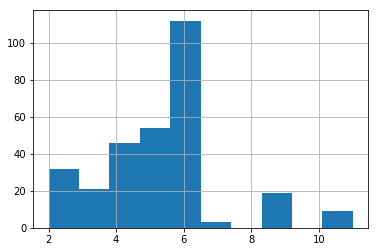

In [68]:
CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
dfmg.loc[CDW & Knox & gline_le_75km, 'JULD'].dt.month.hist()
plt.show()

In [54]:
return_CT_mean(dfmg, Ross & ~gline_le_75km & deepMask250 & sel_months(dfmg, [9]), var='PSAL_ADJUSTED')

(34.78, 0.058851460159631844)

In [56]:
return_CT_mean(dfmg, CDP & gline_le_75km & deepMask250 & sel_months(dfmg,[4]), var='PSAL_ADJUSTED')

(34.41, 0.051620084166300609)

In [57]:
return_CT_mean(dfmg, WPB & gline_le_75km & deepMask250 & sel_months(dfmg,[4]), var='PSAL_ADJUSTED')

(34.42, 0.050070333897054183)

In [58]:
return_CT_mean(dfmg, EPB & gline_le_75km & deepMask250 & sel_months(dfmg,[4]), var='PSAL_ADJUSTED')

(34.39, 0.050076061196312971)

In [48]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask250 & sel_months(dfmg, [12,1,2,3,4,5]), var='CTEMP')

(-1.56, 0.05354828055738458)

In [49]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask250 & sel_months(dfmg, [6,7,8,9,10,11]), var='CTEMP')

(-1.65, 0.072990973788573138)

In [99]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask250 , var='CTEMP')

(-1.58, 0.057130933246517419)

In [100]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250 & sel_months(dfmg, [10]), var='PSAL_ADJUSTED')

(34.4, 0.050094435240992226)

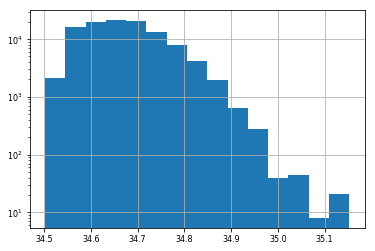

In [108]:
plt.close(1)
fig = plt.figure(1)
ax = plt.subplot()
dfmg.loc[Ross & DSW, "PSAL_ADJUSTED"].hist(bins=15, ax=ax)
ax.set_yscale("log")
plt.show()

In [117]:
print(len(dfmg[DSW & ISW])/len(dfmg[ISW]), len(dfmg[DSW & ISW])/len(dfmg[DSW]),  )

0.5668837576475232 0.3984530190542775


In [23]:
dfmg.loc[Adelie & gline_le_75km, "LATITUDE"].describe()

count    85096.000000
mean       -66.611144
std          0.155670
min        -67.040100
25%        -66.675656
50%        -66.637900
75%        -66.588600
max        -65.503900
Name: LATITUDE, dtype: float64

In [24]:
dfmg.loc[Adelie & gline_le_75km, "LONGITUDE"].describe()

count    85096.000000
mean       140.519755
std          0.920614
min        135.176400
25%        140.004600
50%        140.093571
75%        141.115250
max        144.920700
Name: LONGITUDE, dtype: float64